Processing steps for final calculations after the creation of service areas around Green Quiet Areas (GQA)

#### Step 1 Importing required libraries and load global variables

In [2]:
import geopandas as gpd
import numpy as np
import os
import matplotlib.pyplot as plt
from shapely.geometry import shape, LineString, mapping
from shapely.ops import unary_union, polygonize
import glob
import pandas as pd
import csv
from datetime import datetime


c:\Users\ubach\.conda\envs\geospatial_ETC_DI_v4\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
Q:\UserTemp\ubach\AppData\Local\Temp\3\ipykernel_12536\2717615264.py:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https:

In [3]:
# Define engines
engines = {
    'fiona': {'engine': 'fiona'},
    'pyogrio': {'engine': 'pyogrio'},
    'pyogrio+arrow': {'engine': 'pyogrio', 'use_arrow': True}
          
}

In [4]:
def write_log(log_path, log_entry):
    # Check if the file exists to determine if headers need to be written
    file_exists = os.path.isfile(log_path)

    # Open the log file in append mode
    with open(log_path, 'a', newline='') as csvfile:
        log_writer = csv.writer(csvfile)

        # Write the header if the file is new
        if not file_exists:
            log_writer.writerow(['uc_code', 'uc_name', 'ctry_code', 'TotalUCAreaHa', 'TotalGreenAreaHa',
                                 'green_excludedHa', 'TotalGreenQuietAreaHa', 'PercGreenQuietArea',
                                 'weighted_median_Ha', 'TotalGQAPop', 'TotalPop'])

        # Write the log entry
        log_writer.writerow(log_entry)

def create_log_entry(val1, val2, val3, val4, val5, val6, val7, val8, val9, val10, val11):
    return [val1, val2, val3, val4, val5, val6, val7, val8, val9, val10, val11]


In [5]:
# Path to data folders
indata_f = r'P:\Environment and Health\Noise\ServiceContract\2024_ServiceContract\QuietAreas'
step2_f = os.path.join(indata_f, 'OutputData', 'SA')
outdata_f = r'P:\Environment and Health\Noise\ServiceContract\2024_ServiceContract\QuietAreas\OutputData'
ua_data_f = r'A:\Copernicus\UrbanAtlas\UrbanAtlas\UA2018'
# Load urban center delineation
path = os.path.join(indata_f, 'UrbanCentres', 'HDC2021_RG_InputUpdateB2B3.shp') 
urban_centers = gpd.read_file(path)

# NOISE DATA
# Load agglomerations delineations
agls_file_path = os.path.join(indata_f, 'NoiseData', 'DF1_5_Agglomerations_20240429.gpkg')
# Read the GeoPackage file
agls = gpd.read_file(agls_file_path, layer = 'dbo.DF15_AgglomerationSource_Valid_LatestDelivery', 
                     **engines['pyogrio+arrow'],columns=['agglomerationId_identifier', 'agglomerationName_nameEng', 'geometry'])

ncm_file_path = os.path.join(indata_f, 'NoiseData', f'Noise_20202025_export.gpkg')

# TRANSLATOR TABLE
# Crosswalk table containing the different codes from input sources
codes_path = r'P:\Environment and Health\Noise\ServiceContract\2024_ServiceContract\QuietAreas\Processing\Codes.csv'
codes = pd.read_csv(codes_path)

# GQA
path2FinalGQA = r'P:\Environment and Health\Noise\ServiceContract\2024_ServiceContract\QuietAreas\OutputData\GQA'

# FINAL OUTPUT TABLE
csv_name = 'GQA_v2024_0909.csv'
csv_path = os.path.join(outdata_f, csv_name)

In [118]:
csv_name = 'GQA_v2024_0909_for_dashboard.csv'
csv_path = os.path.join(outdata_f, csv_name)
dashboard = pd.read_csv(csv_path)

In [119]:
dashboard.head()

uc_code    uc_name ctry_code  TotalUCAreaHa  TotalGreenAreaHa  \
0  GEOSTAT21_905    Utrecht        NL         5800.0            566.74   
1  GEOSTAT21_904     Dublin        IE        32700.0           3593.16   
2  GEOSTAT21_903  København        DK        29900.0           3344.86   
3  GEOSTAT21_901   Helsinki        FI        33300.0           8728.36   
4  GEOSTAT21_856    Lemesos        CY         4600.0             83.37   

   green_excludedHa  TotalGreenQuietAreaHa  PercGreenQuietArea  \
0              9.53                 240.73           43.202742   
1              9.41                1829.20           51.041507   
2            307.60                1620.82           53.364546   
3           4394.20                 150.00            3.460878   
4              1.77                  18.24           22.352941   

   weighted_median_Ha  TotalGQAPop  TotalPop  
0               90.11       151051    364839  
1               91.57       485270   1298274  
2               98.44       294470   1100122  
3               88.85         9771   1102678  
4               32.51         6205    165982

In [124]:
dashboard.query('uc_code=="GEOSTAT21_905"')

uc_code  uc_name ctry_code  TotalUCAreaHa  TotalGreenAreaHa  \
0  GEOSTAT21_905  Utrecht        NL         5800.0            566.74   

   green_excludedHa  TotalGreenQuietAreaHa  PercGreenQuietArea  \
0              9.53                 240.73           43.202742   

   weighted_median_Ha  TotalGQAPop  TotalPop  
0               90.11       151051    364839

In [123]:
totals.query('uc_code=="GEOSTAT21_905"')

uc_code  uc_name ctry_code  TotalUCAreaHa  UC_UA_AreaHa  UC_UA_Pop  \
67  GEOSTAT21_905  Utrecht        NL         5800.0        5800.0     341648   

    UC_UA_NCM_AreaHa  UC_UA_NCM_Pop  Perc_coverage_Area  Perc_coverage_Pop  \
67           5768.14         341638               99.45              100.0   

    TotalGreen_urbc_ncm_Ha  TotalGreenQuietAreaHa  TotalGQAPop  \
67                   557.2                 240.73       151051   

    PercGreenQuietArea  PercGreenQuietPop  weighted_median_Ha  \
67           43.203518          44.213758               90.11   

    TotalGreenAreaHa  green_excludedHa  
67            566.74              9.54

In [128]:
totals

uc_code                uc_name ctry_code  TotalUCAreaHa  \
0    GEOSTAT21_022                 Örebro        SE         2700.0   
1    GEOSTAT21_914  Jönköping / Huskvarna        SE         2400.0   
2    GEOSTAT21_026                  Borås        SE         2400.0   
3    GEOSTAT21_070                 Elbląg        PL         1600.0   
4    GEOSTAT21_086                   Kiel        DE         6400.0   
..             ...                    ...       ...            ...   
127  GEOSTAT21_048            Helsingborg        SE         2800.0   
128  GEOSTAT21_177                 Zwolle        NL         3100.0   
129  GEOSTAT21_706                  Porto        PT        22800.0   
130  GEOSTAT21_481                   Wien        AT        25500.0   
131  GEOSTAT21_047                  Århus        DK         7200.0   

     UC_UA_AreaHa  UC_UA_Pop  UC_UA_NCM_AreaHa  UC_UA_NCM_Pop  \
0         2700.00      96771           2700.00          96771   
1         2400.00      70478           2400.00          70478   
2         2400.00      67212           2400.00          67212   
3         1600.00     113020           1586.44         113002   
4         6179.77     223906           5121.94         205100   
..            ...        ...               ...            ...   
127       2717.21     100039           2717.21         100039   
128       3100.00     115098           3100.00         115098   
129      22617.91     853023           7483.86         359668   
130      25500.00    1876792          25284.87        1872474   
131       7050.88     236392           6737.83         236136   

     Perc_coverage_Area  Perc_coverage_Pop  TotalGreen_urbc_ncm_Ha  \
0                100.00             100.00                  569.89   
1                100.00             100.00                  528.42   
2                100.00             100.00                  563.43   
3                 99.15              99.98                  143.86   
4                 80.03              91.60                  648.64   
..                  ...                ...                     ...   
127               97.04             100.00                  359.28   
128              100.00             100.00                  460.63   
129               32.82              42.16                  573.29   
130               99.16              99.77                 3492.85   
131               93.58              99.89                  813.64   

     TotalGreenQuietAreaHa  TotalGQAPop  PercGreenQuietArea  \
0                   139.15        22015           24.416993   
1                   354.01        33655           66.994058   
2                   315.34        26132           55.967911   
3                    70.60        19422           49.075490   
4                   261.42        74141           40.302787   
..                     ...          ...                 ...   
127                  48.41        22005           13.474171   
128                 325.53       103641           70.670603   
129                 381.26       137124           66.503864   
130                2106.55      1093851           60.310348   
131                 603.47        99944           74.169166   

     PercGreenQuietPop  weighted_median_Ha  TotalGreenAreaHa  green_excludedHa  
0            22.749584               88.22            569.89              0.00  
1            47.752490               98.69            528.42              0.00  
2            38.879962               65.28            563.43              0.00  
3            17.187306               29.00            144.42              0.56  
4            36.148708               65.10            814.23            165.59  
..                 ...                 ...               ...               ...  
127          21.996421               79.62            359.28              0.00  
128          90.045874              152.19            460.63              0.00  
129          38.125160               76.00           3025.16  

In [129]:
totals.drop_duplicates('uc_code')

uc_code                uc_name ctry_code  TotalUCAreaHa  \
0    GEOSTAT21_022                 Örebro        SE         2700.0   
1    GEOSTAT21_914  Jönköping / Huskvarna        SE         2400.0   
2    GEOSTAT21_026                  Borås        SE         2400.0   
3    GEOSTAT21_070                 Elbląg        PL         1600.0   
4    GEOSTAT21_086                   Kiel        DE         6400.0   
..             ...                    ...       ...            ...   
126  GEOSTAT21_049                   Lund        SE         2800.0   
127  GEOSTAT21_048            Helsingborg        SE         2800.0   
129  GEOSTAT21_706                  Porto        PT        22800.0   
130  GEOSTAT21_481                   Wien        AT        25500.0   
131  GEOSTAT21_047                  Århus        DK         7200.0   

     UC_UA_AreaHa  UC_UA_Pop  UC_UA_NCM_AreaHa  UC_UA_NCM_Pop  \
0         2700.00      96771           2700.00          96771   
1         2400.00      70478           2400.00          70478   
2         2400.00      67212           2400.00          67212   
3         1600.00     113020           1586.44         113002   
4         6179.77     223906           5121.94         205100   
..            ...        ...               ...            ...   
126       2800.00      89549           2796.82          89537   
127       2717.21     100039           2717.21         100039   
129      22617.91     853023           7483.86         359668   
130      25500.00    1876792          25284.87        1872474   
131       7050.88     236392           6737.83         236136   

     Perc_coverage_Area  Perc_coverage_Pop  TotalGreen_urbc_ncm_Ha  \
0                100.00             100.00                  569.89   
1                100.00             100.00                  528.42   
2                100.00             100.00                  563.43   
3                 99.15              99.98                  143.86   
4                 80.03              91.60                  648.64   
..                  ...                ...                     ...   
126               99.89              99.99                  439.26   
127               97.04             100.00                  359.28   
129               32.82              42.16                  573.29   
130               99.16              99.77                 3492.85   
131               93.58              99.89                  813.64   

     TotalGreenQuietAreaHa  TotalGQAPop  PercGreenQuietArea  \
0                   139.15        22015           24.416993   
1                   354.01        33655           66.994058   
2                   315.34        26132           55.967911   
3                    70.60        19422           49.075490   
4                   261.42        74141           40.302787   
..                     ...          ...                 ...   
126                 234.46        72080           53.376133   
127                  48.41        22005           13.474171   
129                 381.26       137124           66.503864   
130                2106.55      1093851           60.310348   
131                 603.47        99944           74.169166   

     PercGreenQuietPop  weighted_median_Ha  TotalGreenAreaHa  green_excludedHa  
0            22.749584               88.22            569.89              0.00  
1            47.752490               98.69            528.42              0.00  
2            38.879962               65.28            563.43              0.00  
3            17.187306               29.00            144.42              0.56  
4            36.148708               65.10            814.23            165.59  
..                 ...                 ...               ...               ...  
126          80.503032              144.27            441.34              2.08  
127          21.996421               79.62            359.28              0.00  
129          38.125160               76.00           3025.16  

In [171]:
csv_name = 'GQATotals_v2024_1309.csv'
csv_path = os.path.join(outdata_f, csv_name)
totals = pd.read_csv(csv_path)

In [174]:
totals.sort_values('uc_code')

uc_code                uc_name ctry_code  TotalUCAreaHa  \
62   GEOSTAT21_002        Oulu / Uleåborg        FI         2900.0   
15   GEOSTAT21_003                   Umeå        SE         3600.0   
63   GEOSTAT21_006   Tampere / Tammerfors        FI         8200.0   
64   GEOSTAT21_007            Turku / Åbo        FI         7300.0   
65   GEOSTAT21_012                Tallinn        EE         7900.0   
..             ...                    ...       ...            ...   
105  GEOSTAT21_904                 Dublin        IE        32700.0   
67   GEOSTAT21_905                Utrecht        NL         5800.0   
43   GEOSTAT21_907               Augsburg        DE         8300.0   
16   GEOSTAT21_911                  Lahti        FI         2200.0   
1    GEOSTAT21_914  Jönköping / Huskvarna        SE         2400.0   

     UC_UA_AreaHa  UC_UA_Pop  UC_UA_NCM_AreaHa  UC_UA_NCM_Pop  \
62        2900.00      76701           2900.00          76701   
15        3600.00      85430           3600.00          85430   
63        8200.00     196152           8159.01         195838   
64        7287.95     178152           6233.11         165313   
65        7726.22     394795           7623.54         394713   
..            ...        ...               ...            ...   
105      32022.31    1136468          31178.32        1136138   
67        5800.00     341648           5768.14         341638   
43        8300.00     335850           6441.39         282718   
16        2200.00      58883           2200.00          58883   
1         2400.00      70478           2400.00          70478   

     Perc_coverage_Area  Perc_coverage_Pop  TotalGreen_urbc_ncm_Ha  \
62               100.00             100.00                  715.95   
15               100.00             100.00                  949.30   
63                99.50              99.84                 1796.15   
64                85.39              92.79                 1494.97   
65                96.50              99.98                 1513.32   
..                  ...                ...                     ...   
105               95.35              99.97                 3583.76   
67                99.45             100.00                  557.20   
43                77.61              84.18                  972.59   
16               100.00             100.00                  574.28   
1                100.00             100.00                  528.42   

     TotalGreenQuietAreaHa  TotalGQAPop  PercGreenQuietArea  \
62                  340.85        46851           47.608073   
15                  421.74        30019           44.426419   
63                 1016.24       116055           56.578794   
64                 1059.81       104217           70.891724   
65                 1226.97       203870           81.078027   
..                     ...          ...                 ...   
105                1829.20       485270           51.041364   
67                  240.73       151051           43.203518   
43                  659.04        75026           67.761338   
16                  432.49        37270           75.309953   
1                   354.01        33655           66.994058   

     PercGreenQuietPop  weighted_median_Ha  TotalGreenAreaHa  green_excludedHa  
62           61.082646               92.83            715.95              0.00  
15           35.138710               68.09            949.30              0.00  
63           59.260715               95.99           1801.40              5.25  
64           63.042229               96.39           1769.88            274.91  
65           51.650186              126.20           1518.81              5.49  
..                 ...                 ...               ...               ...  
105          42.712241               91.57           3593.16              9.40  
67           44.213758               90.11            566.74              9.54  
43           26.537398               44.23           1041.09  

In [173]:
totals = totals.drop_duplicates()

In [160]:
summary = totals['Perc_coverage_Area'].describe()
print(summary)

count    123.000000
mean      91.814472
std       14.758310
min       19.170000
25%       89.605000
50%       98.450000
75%       99.970000
max      100.000000
Name: Perc_coverage_Area, dtype: float64


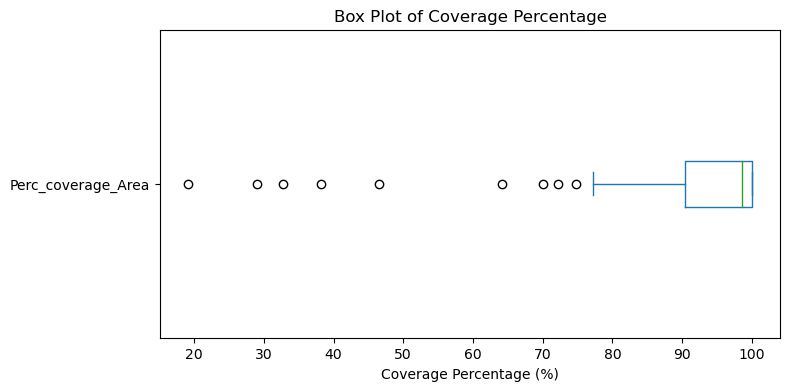

In [138]:
# Create a box plot for percentage coverage
totals['Perc_coverage_Area'].plot(kind='box', vert=False, figsize=(8, 4))

# Add titles and labels
plt.title('Box Plot of Coverage Percentage')
plt.xlabel('Coverage Percentage (%)')
plt.show()

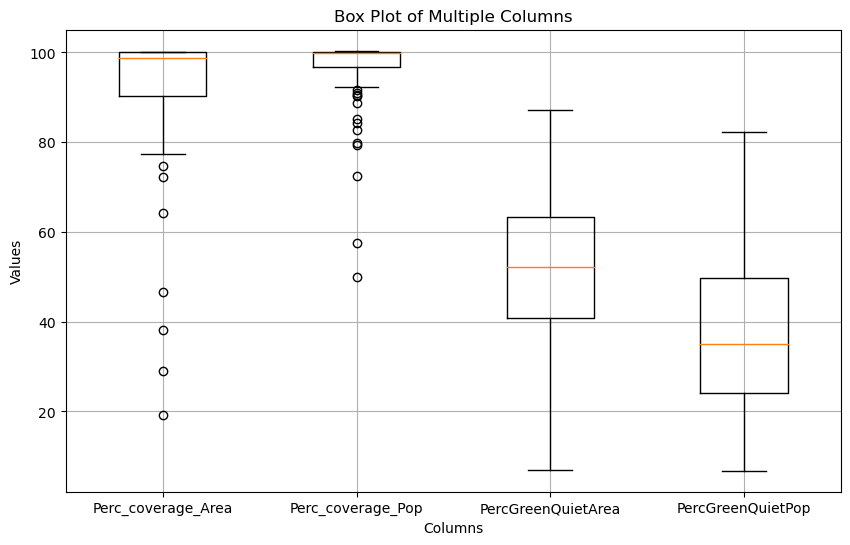

In [25]:
import matplotlib.pyplot as plt

# List of the columns to be plotted
columns_to_plot = ['Perc_coverage_Area', 'Perc_coverage_Pop', 'PercGreenQuietArea', 'PercGreenQuietPop']  # Replace with your column names

# Extract the data from the GeoDataFrame
data_to_plot = [totals[col].dropna() for col in columns_to_plot]  # Drop NaN values for clean plotting

# Create the box plot
plt.figure(figsize=(10, 6))
plt.boxplot(data_to_plot, labels=columns_to_plot)

# Add title and labels
plt.title('Box Plot of Multiple Columns')
plt.xlabel('Columns')
plt.ylabel('Values')
plt.grid(True)

# Show the plot
plt.show()


Q:\UserTemp\ubach\AppData\Local\Temp\3\ipykernel_12536\379844087.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='variable', y='value', data=melted_gdf, palette=palette)


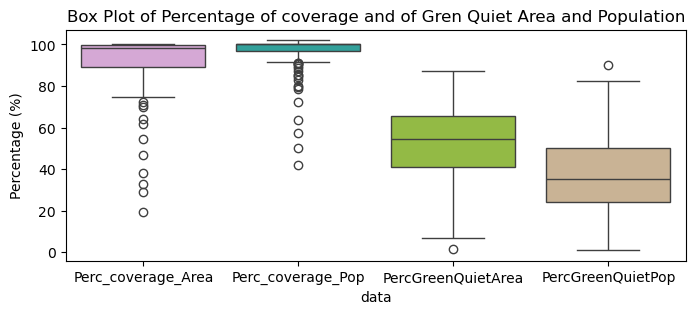

In [177]:
import seaborn as sns
import matplotlib.pyplot as plt

# Melt the GeoDataFrame for seaborn-friendly format
columns_to_plot = ['Perc_coverage_Area', 'Perc_coverage_Pop', 'PercGreenQuietArea', 'PercGreenQuietPop'] 
melted_gdf = totals.melt(value_vars=columns_to_plot)  # Replace with your column names
palette = sns.color_palette(['plum', 'lightseagreen','yellowgreen', 'tan'])

# Create the box plot with seaborn
plt.figure(figsize=(8, 3))
sns.boxplot(x='variable', y='value', data=melted_gdf, palette=palette)

# Add title and labels
plt.title('Box Plot of Percentage of coverage and of Gren Quiet Area and Population')
plt.xlabel('data')
plt.ylabel('Percentage (%)')

# Show the plot
plt.show()


Q:\UserTemp\ubach\AppData\Local\Temp\3\ipykernel_12536\2824443042.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='variable', y='value', data=melted_gdf, palette=palette)


<Figure size 800x300 with 0 Axes>

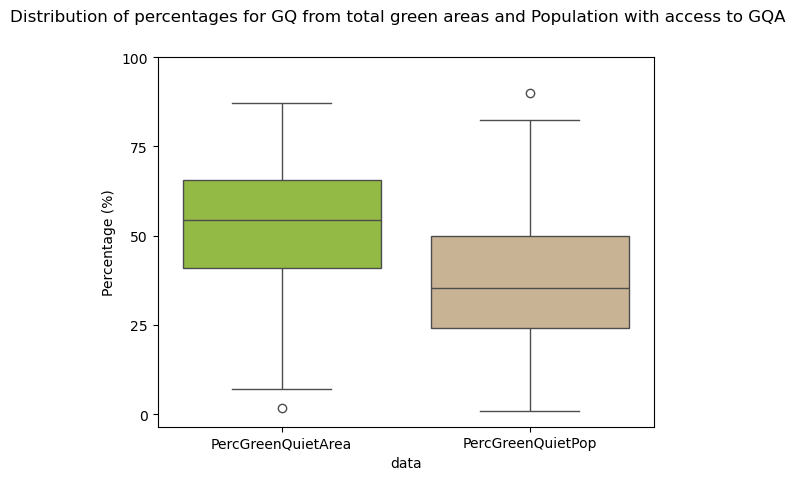

In [178]:
import seaborn as sns
import matplotlib.pyplot as plt

# Melt the GeoDataFrame for seaborn-friendly format
columns_to_plot = ['PercGreenQuietArea', 'PercGreenQuietPop'] 
melted_gdf = totals.melt(value_vars=columns_to_plot)  # Replace with your column names
palette = sns.color_palette(['yellowgreen', 'tan'])

# Create the box plot with seaborn
plt.figure(figsize=(8, 3))
fig, ax = plt.subplots()
sns.boxplot(x='variable', y='value', data=melted_gdf, palette=palette)

# Add title and labels
plt.suptitle('Distribution of percentages for GQ from total green areas and Population with access to GQA')
plt.xlabel('data')
plt.ylabel('Percentage (%)')
ax.set_yticks(np.arange(0, 101, 25)) 

# Show the plot
plt.show()


In [49]:
import pandas as pd
import os

# Define the folder containing the tables
outdata_f = r'P:\Environment and Health\Noise\ServiceContract\2024_ServiceContract\QuietAreas\OutputData'
folder_path = os.path.join(outdata_f, 'OutTables')

# List to store each DataFrame
dataframes = []

# Loop through each file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):  # or any other file format like .xlsx
        # Read the file
        df = pd.read_csv(os.path.join(folder_path, filename))  # use pd.read_excel for .xlsx files
        # Append the DataFrame to the list
        dataframes.append(df)

# Concatenate all DataFrames in the list
merged_df = pd.concat(dataframes, ignore_index=True)

# Save to a new file or perform further analysis
#merged_df.to_csv("merged_table.csv", index=False)
merged_df2 = merged_df.drop_duplicates('uc_code')
merged_df2 = merged_df2.sort_values(by='uc_code', ascending=True) 

In [50]:
merged_df2

uc_code                                         uc_name ctry_code  \
59  GEOSTAT21_002                                 Oulu / Uleåborg        FI   
60  GEOSTAT21_003                                            Umeå        SE   
61  GEOSTAT21_004                                       Trondheim        NO   
62  GEOSTAT21_005                                       Jyväskylä        FI   
63  GEOSTAT21_006                            Tampere / Tammerfors        FI   
..            ...                                             ...       ...   
78  GEOSTAT21_914                           Jönköping / Huskvarna        SE   
79  GEOSTAT21_919  Neu Wulmstorf / Neugraben-Fischbek / Hausbruch        DE   
67  GEOSTAT21_922                      Scharwoude / Heerhugowaard        NL   
68  GEOSTAT21_925                                       Wuppertal        DE   
69  GEOSTAT21_945                            Saint-Priest / Mions        FR   

    TotalUCAreaHa  UC_UA_AreaHa  UC_UA_Pop  UC_UA_NCM_AreaHa  UC_UA_NCM_Pop  \
59         2900.0       2900.00      76701           2900.00          76701   
60         3600.0       3600.00      85430           3600.00          85430   
61         7000.0       6792.94     177126           6669.17         177123   
62         2700.0       2700.00      64379           2700.00          64379   
63         8200.0       8200.00     196152           8159.01         195838   
..            ...           ...        ...               ...            ...   
78         2400.0       2400.00      70478           2400.00          70478   
79         1700.0       1700.00      59435           1164.81          45247   
67         2100.0       2100.00      70637           2100.00          70637   
68         6200.0        133.13       3782            133.13           3947   
69         1300.0       1300.00      50619           1300.00          50619   

    Perc_coverage_Area  Perc_coverage_Pop  TotalGreen_urbc_ncm_Ha  \
59              100.00             100.00                  715.95   
60              100.00             100.00                  949.30   
61               95.27             100.00                 1289.85   
62              100.00             100.00                  603.42   
63               99.50              99.84                 1796.15   
..                 ...                ...                     ...   
78              100.00             100.00                  528.42   
79               68.52              76.13                  168.70   
67              100.00             100.00                  283.68   
68                2.15             104.36                   38.74   
69              100.00             100.00                   25.59   

    TotalGreenQuietAreaHa  TotalGQAPop  PercGreenQuietArea  PercGreenQuietPop  \
59                 340.85        72914           47.608073          95.062646   
60                 421.74        60627           44.426419          70.966873   
61                 954.85       164537           74.027988          92.894203   
62                 369.46        62105           61.227669          96.467792   
63                1016.24       179772           56.578794          91.796281   
..                    ...          ...                 ...                ...   
78                 354.01        55630           66.994058          78.932433   
79                 134.87        41834           79.946651          92.456958   
67                 174.15        64388           61.389594          91.153362   
68                 666.06          647         1719.308209          16.392197   
69                  16.65        29996           65.064478          59.258381   

    weighted_median_Ha  TotalGreenAreaHa  green_excludedHa  
59                2.37            715.95              0.00  
60                7.67            949.30              0.00  
61                6.68           1307.75             17.90  
62                5.46            603.42              0.00  
63   

In [53]:
merged_df2.query('uc_code== "GEOSTAT21_906"')

uc_code uc_name ctry_code  TotalUCAreaHa  UC_UA_AreaHa  UC_UA_Pop  \
160  GEOSTAT21_906   Paris        FR       143200.0      143200.0    9538015   

     UC_UA_NCM_AreaHa  UC_UA_NCM_Pop  Perc_coverage_Area  Perc_coverage_Pop  \
160          142155.0        9629278               99.27             100.96   

     TotalGreen_urbc_ncm_Ha  TotalGreenQuietAreaHa  TotalGQAPop  \
160                21018.83               11799.19      5597009   

     PercGreenQuietArea  PercGreenQuietPop  weighted_median_Ha  \
160           56.136284          58.124908                1.23   

     TotalGreenAreaHa  green_excludedHa  
160          21320.82            301.99

In [ ]:
merged_df2


In [55]:
csv_name = 'GQATotals_v2024_3010_preliminary4.csv'
csv_path = os.path.join(outdata_f, csv_name)
merged_df2.to_csv(csv_path, index=False, encoding="utf-8-sig")

In [28]:
merged_df.query('uc_code=="GEOSTAT21_299"')

uc_code     uc_name ctry_code  TotalUCAreaHa  UC_UA_AreaHa  \
192  GEOSTAT21_299  Ruhrgebiet        DE        96900.0       96900.0   

     UC_UA_Pop  UC_UA_NCM_AreaHa  UC_UA_NCM_Pop  Perc_coverage_Area  \
192    2874904          81847.16        2562732               84.47   

     Perc_coverage_Pop  TotalGreen_urbc_ncm_Ha  TotalGreenQuietAreaHa  \
192              89.14                13153.95                7009.57   

     TotalGQAPop  PercGreenQuietArea  PercGreenQuietPop  weighted_median_Ha  \
192      1932988           53.288708          75.426849                 4.5   

     TotalGreenAreaHa  green_excludedHa  
192          15976.28           2822.33

uc_code               uc_name ctry_code  TotalUCAreaHa  \
63   GEOSTAT21_002       Oulu / Uleåborg        FI         2900.0   
64   GEOSTAT21_003                  Umeå        SE         3600.0   
65   GEOSTAT21_004             Trondheim        NO         7000.0   
66   GEOSTAT21_005             Jyväskylä        FI         2700.0   
67   GEOSTAT21_006  Tampere / Tammerfors        FI         8200.0   
..             ...                   ...       ...            ...   
98   GEOSTAT21_689             Marseille        FR        13900.0   
99   GEOSTAT21_694               Logroño        ES         1600.0   
100  GEOSTAT21_706                 Porto        PT        22800.0   
101  GEOSTAT21_712            Valladolid        ES         3700.0   
102  GEOSTAT21_768     Torrejón de Ardoz        ES         1200.0   

     UC_UA_AreaHa  UC_UA_Pop  UC_UA_NCM_AreaHa  UC_UA_NCM_Pop  \
63        2900.00      76701           2900.00          76701   
64        3600.00      85430           3600.00          85430   
65        6792.94     177126           6669.17         177123   
66        2700.00      64379           2700.00          64379   
67        8200.00     196152           8159.01         195838   
..            ...        ...               ...            ...   
98       13636.62     870681          13355.54         870681   
99        1600.00     149314           1590.32         148887   
100      22617.91     853023           7483.86         359668   
101       3700.00     307004           3103.65         289874   
102       1200.00     127388           1142.95         127367   

     Perc_coverage_Area  Perc_coverage_Pop  TotalGreen_urbc_ncm_Ha  \
63               100.00             100.00                  715.95   
64               100.00             100.00                  949.30   
65                95.27             100.00                 1289.85   
66               100.00             100.00                  603.42   
67                99.50              99.84                 1796.15   
..                  ...                ...                     ...   
98                96.08             100.00                 1371.01   
99                99.40              99.71                  177.26   
100               32.82              42.16                  573.29   
101               83.88              94.42                  409.08   
102               95.25              99.98                  103.28   

     TotalGreenQuietAreaHa  TotalGQAPop  PercGreenQuietArea  \
63                  340.85        72914           47.608073   
64                  421.74        60627           44.426419   
65                  954.85       164537           74.027988   
66                  369.46        62105           61.227669   
67                 1016.24       179772           56.578794   
..                     ...          ...                 ...   
98                  893.05       615364           65.138110   
99                   12.49        69813            7.046147   
100                 381.26       274824           66.503864   
101                 189.65       223348           46.360125   
102                  29.14        88809           28.214562   

     PercGreenQuietPop  weighted_median_Ha  TotalGreenAreaHa  green_excludedHa  
63           95.062646                2.37            715.95              0.00  
64           70.966873                7.67            949.30              0.00  
65           92.894203                6.68           1307.75             17.90  
66           96.467792                5.46            603.42              0.00  
67           91.796281                3.37           1801.40              5.25  
..                 ...                 ...               ...               ...  
98           70.676172                1.69           1371.08              0.07  
99           46.889923                0.22            177.77              0.51  
100          76.410467                2.69           3025.16           245

In [8]:
merged_df['PercGreenQuietArea'].describe()

count    102.000000
mean      53.195773
std       16.312999
min       13.333936
25%       42.363516
50%       52.914670
75%       63.838554
max       87.708730
Name: PercGreenQuietArea, dtype: float64

In [179]:
summary = totals['PercGreenQuietArea'].describe()
print(summary)

count    128.000000
mean      52.120952
std       17.627614
min        1.718648
25%       40.860188
50%       54.479421
75%       65.479548
max       87.156422
Name: PercGreenQuietArea, dtype: float64


In [180]:
summary = totals['PercGreenQuietPop'].describe()
print(summary)

count    128.000000
mean      37.560205
std       18.434116
min        0.962328
25%       24.140743
50%       35.314073
75%       49.918254
max       90.045874
Name: PercGreenQuietPop, dtype: float64


In [148]:
totals.query('PercGreenQuietArea<10')

uc_code   uc_name ctry_code  TotalUCAreaHa  UC_UA_AreaHa  \
59   GEOSTAT21_694   Logroño        ES         1600.0       1600.00   
122  GEOSTAT21_901  Helsinki        FI        33300.0      31666.74   

     UC_UA_Pop  UC_UA_NCM_AreaHa  UC_UA_NCM_Pop  Perc_coverage_Area  \
59      149314           1590.32         148887               99.40   
122     995310          31660.37        1015350               95.08   

     Perc_coverage_Pop  TotalGreen_urbc_ncm_Ha  TotalGreenQuietAreaHa  \
59               99.71                  177.26                  12.49   
122             102.01                 8727.79                 150.00   

     TotalGQAPop  PercGreenQuietArea  PercGreenQuietPop  weighted_median_Ha  \
59         24085            7.046147          16.176698               35.94   
122         9771            1.718648           0.962328               88.85   

     TotalGreenAreaHa  green_excludedHa  
59             177.77              0.51  
122           8728.36              0.57

In [154]:
totals.query('PercGreenQuietArea>80').drop_duplicates()[['uc_name', 'ctry_code','UC_UA_NCM_AreaHa', 'Perc_coverage_Area', 'Perc_coverage_Pop','PercGreenQuietArea', 'PercGreenQuietPop']].sort_values('PercGreenQuietArea')

uc_name ctry_code  UC_UA_NCM_AreaHa  Perc_coverage_Area  \
65         Tallinn        EE           7623.54               96.50   
36          Kielce        PL           2700.00              100.00   
91  Ústí nad Labem        CZ           1569.48               98.09   
48      Heidelberg        DE           3099.82               99.99   
5          Olsztyn        PL           2632.32               90.77   

    Perc_coverage_Pop  PercGreenQuietArea  PercGreenQuietPop  
65              99.98           81.078027          51.650186  
36             100.00           81.225048          21.439970  
91              99.92           82.370007          56.181467  
48             100.00           82.404571          29.144485  
5               98.09           87.156422          55.801137

In [170]:
totals.drop_duplicates().sort_values('TotalGreenQuietAreaHa')[['uc_name', 'TotalGreenQuietAreaHa','UC_UA_NCM_AreaHa', 'Perc_coverage_Area', 'Perc_coverage_Pop','PercGreenQuietArea', 'PercGreenQuietPop']].tail()

uc_name  TotalGreenQuietAreaHa  UC_UA_NCM_AreaHa  Perc_coverage_Area  \
117  København                1620.82          26670.16               89.20   
103   Warszawa                1663.51          27566.34               84.30   
105     Dublin                1829.20          31178.32               95.35   
106       Köln                2087.03          23286.33               99.09   
130       Wien                2106.55          25284.87               99.16   

     Perc_coverage_Pop  PercGreenQuietArea  PercGreenQuietPop  
117              94.58           53.364721          31.580652  
103              90.99           39.649296          27.130692  
105              99.97           51.041364          42.712241  
106             100.08           43.024272          25.950747  
130              99.77           60.310348          58.417420

In [157]:
totals.query('PercGreenQuietPop>80').drop_duplicates()[['uc_name', 'ctry_code','UC_UA_NCM_AreaHa', 'Perc_coverage_Area', 'Perc_coverage_Pop','PercGreenQuietArea', 'PercGreenQuietPop']].sort_values('PercGreenQuietPop')

uc_name ctry_code  UC_UA_NCM_AreaHa  Perc_coverage_Area  \
126       Lund        SE           2796.82               99.89   
19   Apeldoorn        NL           3600.00              100.00   
97      Zwolle        NL           3100.00              100.00   

     Perc_coverage_Pop  PercGreenQuietArea  PercGreenQuietPop  
126              99.99           53.376133          80.503032  
19              100.00           60.521345          82.320192  
97              100.00           70.670603          90.045874

In [117]:
totals.query('uc_code=="GEOSTAT21_018"')

Empty DataFrame
Columns: [uc_code, uc_name, ctry_code, TotalUCAreaHa, UC_UA_AreaHa, UC_UA_Pop, UC_UA_NCM_AreaHa, UC_UA_NCM_Pop, Perc_coverage_Area, Perc_coverage_Pop, TotalGreen_urbc_ncm_Ha, TotalGreenQuietAreaHa, TotalGQAPop, PercGreenQuietArea, PercGreenQuietPop, weighted_median_Ha, TotalGreenAreaHa, green_excludedHa]
Index: []

In [130]:
totals.query('Perc_coverage_Area<50').drop_duplicates()

uc_code                 uc_name ctry_code  TotalUCAreaHa  \
40   GEOSTAT21_408                   Mainz        DE         5600.0   
57   GEOSTAT21_652  San Sebastián/Donostia        ES         3100.0   
76   GEOSTAT21_650                  Bilbao        ES         7700.0   
90   GEOSTAT21_364                   Liège        BE        11900.0   
129  GEOSTAT21_706                   Porto        PT        22800.0   

     UC_UA_AreaHa  UC_UA_Pop  UC_UA_NCM_AreaHa  UC_UA_NCM_Pop  \
40        1081.49      27778           1073.67          27778   
57        2956.41     238250           1442.98         172777   
76        7495.99     767507           2236.01         442007   
90       11900.00     380065           4549.37         189673   
129      22617.91     853023           7483.86         359668   

     Perc_coverage_Area  Perc_coverage_Pop  TotalGreen_urbc_ncm_Ha  \
40                19.17             100.00                   81.15   
57                46.55              72.52                  158.60   
76                29.04              57.59                  222.84   
90                38.23              49.91                  661.31   
129               32.82              42.16                  573.29   

     TotalGreenQuietAreaHa  TotalGQAPop  PercGreenQuietArea  \
40                   61.76         7167           76.105977   
57                   46.55        60266           29.350567   
76                   44.71       160402           20.063723   
90                  414.08        56188           62.615112   
129                 381.26       137124           66.503864   

     PercGreenQuietPop  weighted_median_Ha  TotalGreenAreaHa  green_excludedHa  
40           25.800994               25.73             81.15              0.00  
57           34.880800               33.23            533.42            374.82  
76           36.289471               89.44            690.88            468.04  
90           29.623615               67.83           1579.02            917.71  
129          38.125160               76.00           3025.16           2451.87

In [131]:
totals.query('Perc_coverage_Area<50').drop_duplicates()[['uc_code', 'uc_name', 'TotalUCAreaHa','UC_UA_NCM_AreaHa', 'Perc_coverage_Area', 'Perc_coverage_Pop']]

uc_code                 uc_name  TotalUCAreaHa  UC_UA_NCM_AreaHa  \
40   GEOSTAT21_408                   Mainz         5600.0           1073.67   
57   GEOSTAT21_652  San Sebastián/Donostia         3100.0           1442.98   
76   GEOSTAT21_650                  Bilbao         7700.0           2236.01   
90   GEOSTAT21_364                   Liège        11900.0           4549.37   
129  GEOSTAT21_706                   Porto        22800.0           7483.86   

     Perc_coverage_Area  Perc_coverage_Pop  
40                19.17             100.00  
57                46.55              72.52  
76                29.04              57.59  
90                38.23              49.91  
129               32.82              42.16

In [113]:
totals.query('Perc_coverage_Pop<50')

uc_code uc_name ctry_code  TotalUCAreaHa  UC_UA_AreaHa  UC_UA_Pop  \
90  GEOSTAT21_364   Liège        BE        11900.0       11900.0     380065   
99  GEOSTAT21_364   Liège        BE        11900.0       11900.0     380065   

    UC_UA_NCM_AreaHa  UC_UA_NCM_Pop  Perc_coverage_Area  Perc_coverage_Pop  \
90           4549.37         189673               38.23              49.91   
99           4549.37         189673               38.23              49.91   

    TotalGreen_urbc_ncm_Ha  TotalGreenQuietAreaHa  TotalGQAPop  \
90                  661.31                 414.08        56188   
99                  661.31                 414.08        56188   

    PercGreenQuietArea  PercGreenQuietPop  weighted_median_Ha  \
90           62.615112          29.623615               67.83   
99           62.615112          29.623615               67.83   

    TotalGreenAreaHa  green_excludedHa  
90           1579.02            917.71  
99           1579.02            917.71

## plotting cities with low coverage values

In [40]:
uc_code = 'GEOSTAT21_408'
uc_name = 'Mainz'
urban_center = urban_centers.query(f'HDENS_CLST=="{uc_code}"')
# Read Urban Atlas data
ua_path = codes.query(f'HDENS_CLST=="{uc_code}"').UA2018.values[0].strip()
file_path = os.path.join(ua_data_f, f'{ua_path}\Data\{ua_path}.gpkg')
# Read the GeoPackage file
ua = gpd.read_file(file_path, layer= ua_path[:-5], 
            columns= ['code_2018','Pop2018','geometry'], engine='pyogrio', 
            use_arrow=True, bbox= tuple(urban_center.total_bounds))

ua_urbc = gpd.overlay(ua, urban_center, how='intersection')
ua_urbc_agl = gpd.overlay(ua_urbc, agls, how='intersection')

Q:\UserTemp\ubach\AppData\Local\Temp\3\ipykernel_12536\3173761813.py:16: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


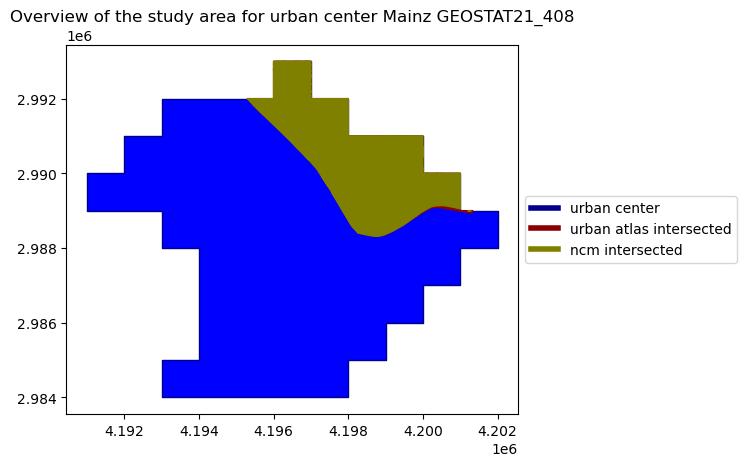

In [51]:
# Plot both GeoDataFrames on the same axis
fig, ax = plt.subplots()

# Plot the first GeoDataFrame
urban_center.plot(ax=ax, color='blue', edgecolor='darkblue', label = 'urban center')

# Plot the second GeoDataFrame
ua_urbc.plot(ax=ax, color='darkred', edgecolor='darkred', label = 'urban atlas intersected')

ua_urbc_agl.plot(ax=ax, color='olive', edgecolor='olive', label = 'ncm intersected')

# Add title and labels
ax.set_title(f'Overview of the study area for urban center {uc_name} {uc_code}')

# Create custom labels in the legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=[plt.Line2D([0], [0], color='darkblue', lw=4),
                   plt.Line2D([0], [0], color='darkred', lw=4),
                   plt.Line2D([0], [0], color='olive', lw=4)],
          labels=['urban center', 'urban atlas intersected', 'ncm intersected'],
          loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [52]:
uc_code = 'GEOSTAT21_650'
uc_name = 'Bilbao'
urban_center = urban_centers.query(f'HDENS_CLST=="{uc_code}"')
# Read Urban Atlas data
ua_path = codes.query(f'HDENS_CLST=="{uc_code}"').UA2018.values[0].strip()
file_path = os.path.join(ua_data_f, f'{ua_path}\Data\{ua_path}.gpkg')
# Read the GeoPackage file
ua = gpd.read_file(file_path, layer= ua_path[:-5], 
            columns= ['code_2018','Pop2018','geometry'], engine='pyogrio', 
            use_arrow=True, bbox= tuple(urban_center.total_bounds))

ua_urbc = gpd.overlay(ua, urban_center, how='intersection')
ua_urbc_agl = gpd.overlay(ua_urbc, agls, how='intersection')

Q:\UserTemp\ubach\AppData\Local\Temp\3\ipykernel_12536\3622728531.py:12: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ua_urbc = gpd.overlay(ua, urban_center, how='intersection')


Q:\UserTemp\ubach\AppData\Local\Temp\3\ipykernel_12536\1137817679.py:17: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


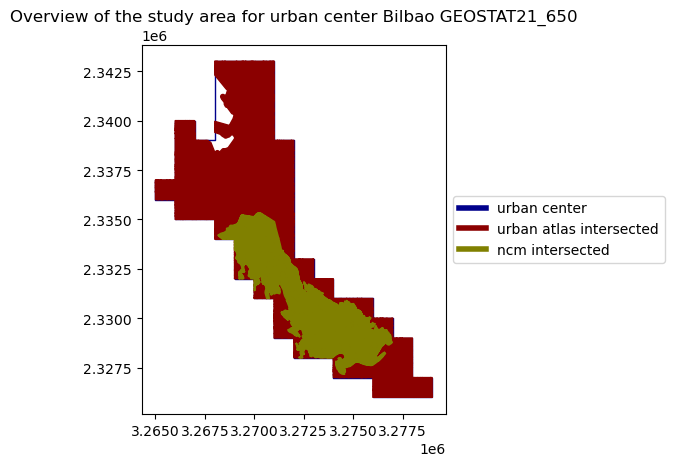

In [55]:
# Plot both GeoDataFrames on the same axis
fig, ax = plt.subplots()

# Plot the first GeoDataFrame
#urban_center.plot(ax=ax, color='blue', edgecolor='darkblue', label = 'urban center')
urban_center.plot(ax=ax, color='white', edgecolor='darkblue', label = 'urban center')

# Plot the second GeoDataFrame
ua_urbc.plot(ax=ax, color='darkred', edgecolor='darkred', label = 'urban atlas intersected')

ua_urbc_agl.plot(ax=ax, color='olive', edgecolor='olive', label = 'ncm intersected')

# Add title and labels
ax.set_title(f'Overview of the study area for urban center {uc_name} {uc_code}')

# Create custom labels in the legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=[plt.Line2D([0], [0], color='darkblue', lw=4),
                   plt.Line2D([0], [0], color='darkred', lw=4),
                   plt.Line2D([0], [0], color='olive', lw=4)],
          labels=['urban center', 'urban atlas intersected', 'ncm intersected'],
          loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

Q:\UserTemp\ubach\AppData\Local\Temp\3\ipykernel_12536\1839935367.py:15: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


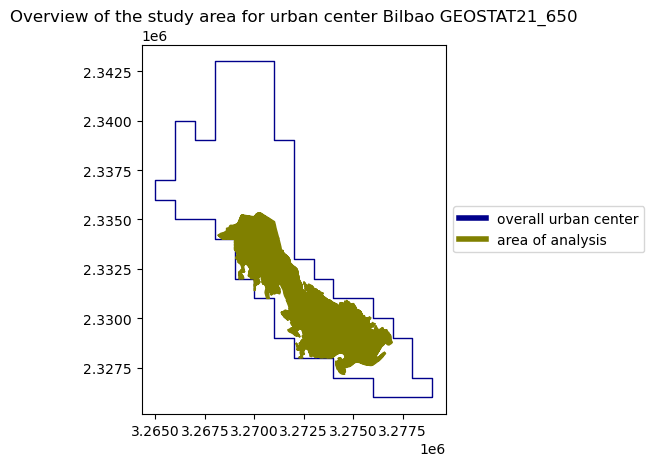

In [57]:
# Plot both GeoDataFrames on the same axis
fig, ax = plt.subplots()

# Plot the first GeoDataFrame
#urban_center.plot(ax=ax, color='blue', edgecolor='darkblue', label = 'urban center')
urban_center.plot(ax=ax, color='white', edgecolor='darkblue', label = 'urban center')

# Plot the second GeoDataFrame
ua_urbc_agl.plot(ax=ax, color='olive', edgecolor='olive', label = 'ncm intersected')

# Add title and labels
ax.set_title(f'Overview of the study area for urban center {uc_name} {uc_code}')

# Create custom labels in the legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=[plt.Line2D([0], [0], color='darkblue', lw=4),
                   plt.Line2D([0], [0], color='olive', lw=4)],
          labels=['overall urban center', 'area of analysis'],
          loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

Q:\UserTemp\ubach\AppData\Local\Temp\3\ipykernel_12536\2619164499.py:26: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


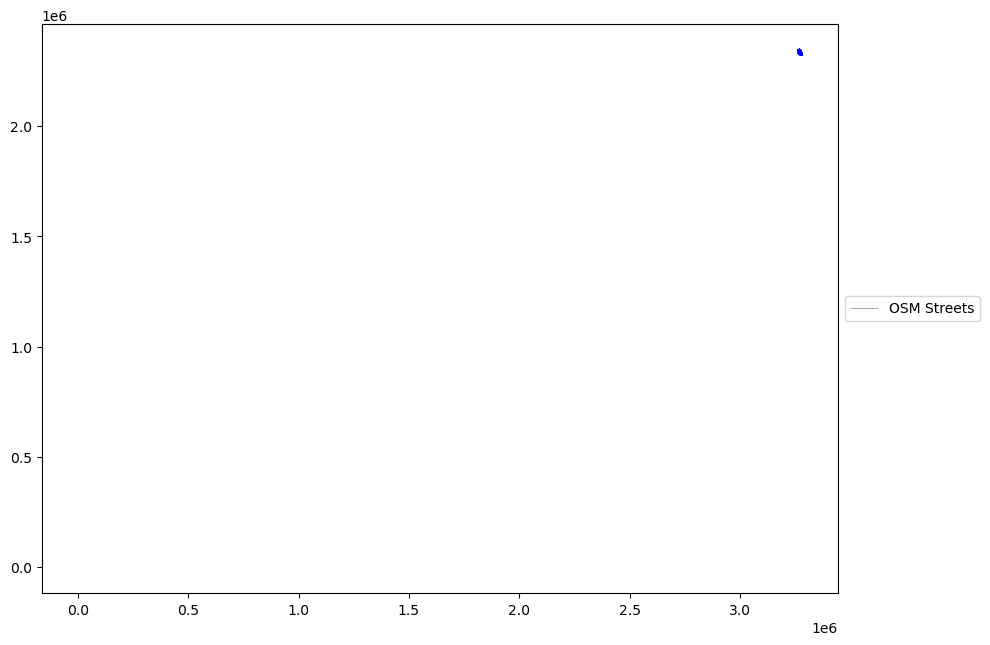

In [56]:
import geopandas as gpd
import osmnx as ox
import matplotlib.pyplot as plt


# Fetch OSM street network data for a specific region (e.g., by city name or coordinates)
# For example, fetch street network data for Manhattan
osm_graph = ox.graph_from_place('Bilbao', network_type='all')

# Convert the OSM graph into a GeoDataFrame (edges of the street network)
osm_edges = ox.graph_to_gdfs(osm_graph, nodes=False)

# Create a plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the OSM street network
osm_edges.plot(ax=ax, linewidth=0.5, edgecolor='gray', label='OSM Streets')


# Plot GeoDataFrames with boundary data
urban_center.plot(ax=ax, edgecolor='red', linewidth=2, label='urban center')
ua_urbc.plot(ax=ax, edgecolor='blue', linewidth=2, label='urban atlas intersected')
ua_urbc_agl.plot(ax=ax, edgecolor='blue', linewidth=2, label='ncm intersected')

# Add a legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust the layout to make room for the legend
plt.tight_layout()

# Show the plot
plt.show()


Q:\UserTemp\ubach\AppData\Local\Temp\3\ipykernel_12536\1951999445.py:22: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_bbox(north, south, east, west, tags={'building': True})
Q:\UserTemp\ubach\AppData\Local\Temp\3\ipykernel_12536\1951999445.py:25: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  parks = ox.geometries_from_bbox(north, south, east, west, tags={'leisure': 'park'})
Q:\UserTemp\ubach\AppData\Local\Temp\3\ipykernel_12536\1951999445.py:28: UserWarning: The `geometries` module and `geometries_from_X` functions have been r

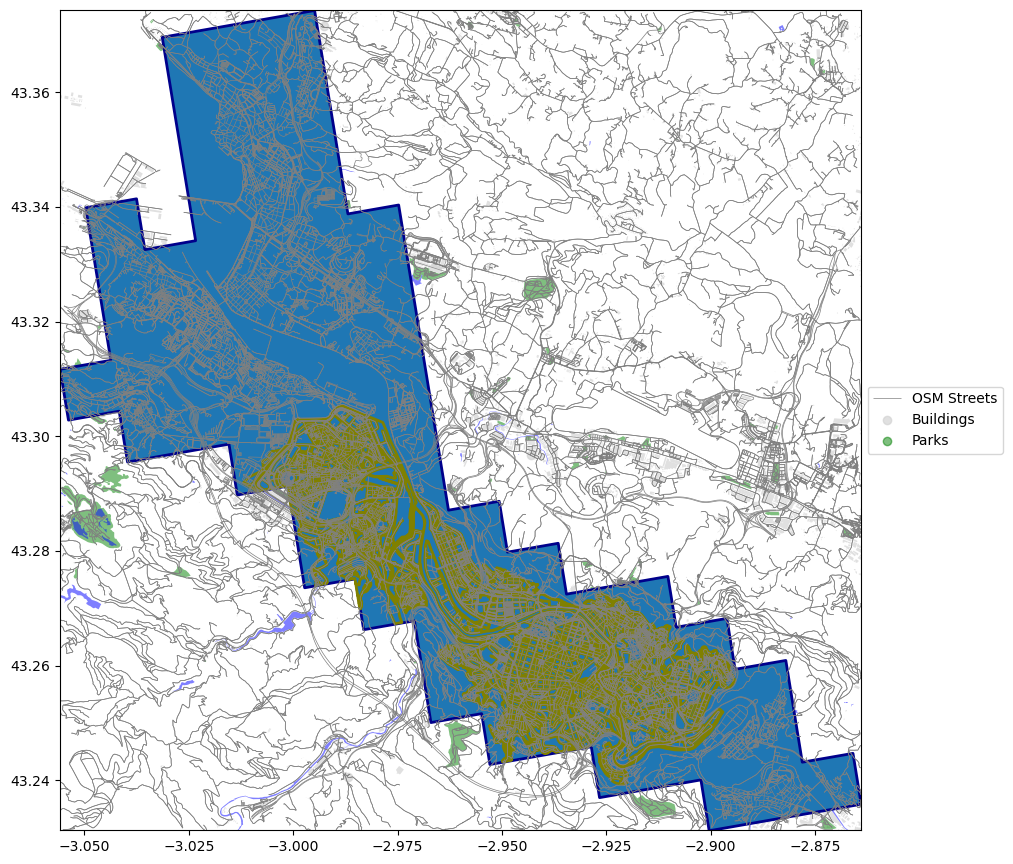

In [60]:
import geopandas as gpd
import osmnx as ox
import matplotlib.pyplot as plt

urban_center4326 = urban_center.to_crs(epsg=4326)
ua_urbc_agl4326 = ua_urbc_agl.to_crs(epsg=4326)

# Extract the bounding box from the first GeoDataFrame
bbox = urban_center4326.total_bounds
north, south, east, west = bbox[3], bbox[1], bbox[2], bbox[0]

# Fetch OSM data within the bounding box
# Note: OSM data extraction is more efficient with a bounding box
# Fetch street network data within the bounding box
osm_graph = ox.graph_from_bbox(north, south, east, west, network_type='all')

# Convert the OSM graph into a GeoDataFrame (edges of the street network)
osm_edges = ox.graph_to_gdfs(osm_graph, nodes=False)

# Fetch additional OSM layers within the bounding box
# Buildings
buildings = ox.geometries_from_bbox(north, south, east, west, tags={'building': True})

# Parks (green areas)
parks = ox.geometries_from_bbox(north, south, east, west, tags={'leisure': 'park'})

# Water bodies
water = ox.geometries_from_bbox(north, south, east, west, tags={'natural': 'water'})

# Create a plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the OSM street network
osm_edges.plot(ax=ax, linewidth=0.5, edgecolor='gray', label='OSM Streets')

# Plot additional OSM layers
buildings.plot(ax=ax, color='lightgray', alpha=0.7, label='Buildings')
parks.plot(ax=ax, color='green', alpha=0.5, label='Parks')
water.plot(ax=ax, color='blue', alpha=0.5, label='Water')

# Plot GeoDataFrames with boundary data
urban_center4326.plot(ax=ax, edgecolor='darkblue', linewidth=2, label='urban center')
ua_urbc_agl4326.plot(ax=ax, edgecolor='olive', linewidth=2, label='area of study')


# Set the plot limits to match the bounding box
ax.set_xlim(west, east)
ax.set_ylim(south, north)

# Add a legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust the layout to make room for the legend
plt.tight_layout()

# Show the plot
plt.show()


Q:\UserTemp\ubach\AppData\Local\Temp\3\ipykernel_12536\1493908449.py:28: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


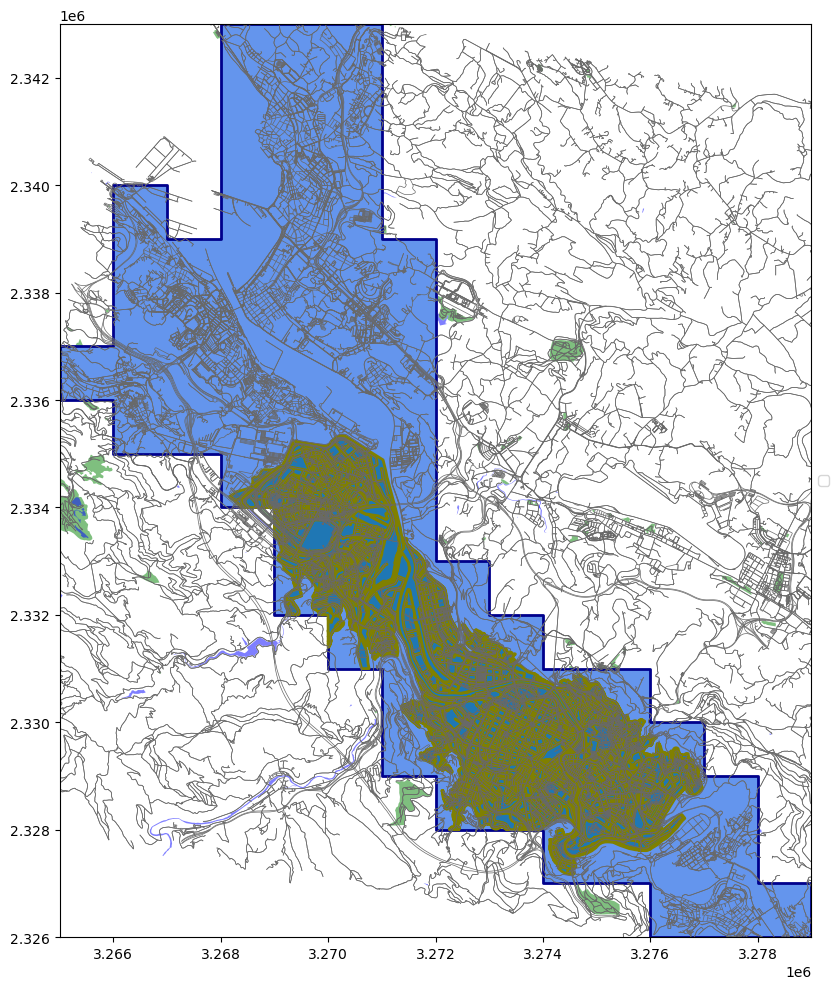

In [63]:
# Create a plot
fig, ax = plt.subplots(figsize=(10, 10))
osm_edges3035 = osm_edges.to_crs(epsg=3035)
parks3035 = parks.to_crs(epsg=3035)
osm_edges3035 = osm_edges.to_crs(epsg=3035)
water3035 = water.to_crs(epsg=3035)

bbox = urban_center.total_bounds
north, south, east, west = bbox[3], bbox[1], bbox[2], bbox[0]

# Plot the OSM street network
osm_edges3035.plot(ax=ax, linewidth=0.5, color = 'dimgrey', edgecolor='gray')

# Plot additional OSM layers
parks3035.plot(ax=ax, color='green', alpha=0.5)
water3035.plot(ax=ax, color='blue', alpha=0.5)

# Plot GeoDataFrames with boundary data
urban_center.plot(ax=ax, color= 'cornflowerblue', edgecolor='darkblue', linewidth=2, label='urban center')
ua_urbc_agl.plot(ax=ax, edgecolor='olive', linewidth=2, label='area of study')


# Set the plot limits to match the bounding box
ax.set_xlim(west, east)
ax.set_ylim(south, north)

# Add a legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust the layout to make room for the legend
plt.tight_layout()

# Show the plot
plt.show()

In [67]:
# Load coastline data from Natural Earth via geopandas
coastlines = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
coastlines = coastlines[coastlines['continent'].notnull()]

In [65]:
pip install geopandas naturalearth

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement naturalearth (from versions: none)
ERROR: No matching distribution found for naturalearth
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x19e3de00400>
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x19e6ec1c2e0>
c:\Users\ubach\.conda\envs\geospatial_ETC_DI_v4\lib\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning: unclosed file <_io.BufferedWriter name=5>
  return process_handler(cmd, _system_body)
c:\Users\ubach\.conda\envs\geospatial_ETC_DI_v4\lib\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning: unclosed file <_io.BufferedReader name=6>
  return process_handler(cmd, _system_body)
c:\Users\ubach\.conda\envs\geospatial_ETC_DI_v4\lib\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning: unclosed file <_io.BufferedReader name=7>
  return process_handler(cmd, _system_body)


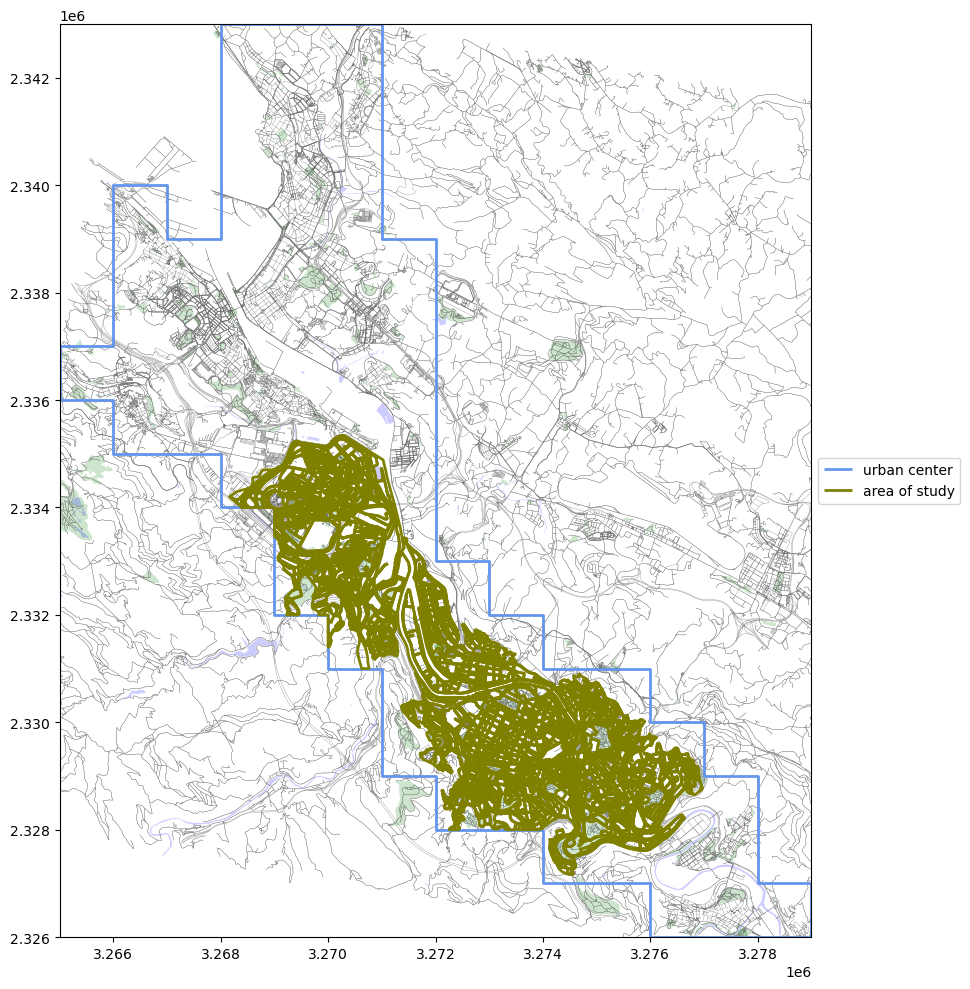

In [69]:

# Create a plot
fig, ax = plt.subplots(figsize=(10, 10))
osm_edges3035 = osm_edges.to_crs(epsg=3035)
parks3035 = parks.to_crs(epsg=3035)
osm_edges3035 = osm_edges.to_crs(epsg=3035)
water3035 = water.to_crs(epsg=3035)
# Plot the coastlines
coastline3035 =coastlines.to_crs(epsg=3035)

bbox = urban_center.total_bounds
north, south, east, west = bbox[3], bbox[1], bbox[2], bbox[0]

# Plot the OSM street network
osm_edges3035.plot(ax=ax, linewidth=0.2, color = 'dimgrey', edgecolor='gray')

# Plot additional OSM layers
parks3035.plot(ax=ax, color='green', alpha=0.2)
water3035.plot(ax=ax, color='blue', alpha=0.2)


# Plot GeoDataFrames with boundary data
urban_center.boundary.plot(ax=ax, color= 'cornflowerblue', edgecolor='darkblue',linewidth=2, label='urban center')
ua_urbc_agl.boundary.plot(ax=ax, edgecolor='olive', linewidth=2, label='area of study')


# Set the plot limits to match the bounding box
ax.set_xlim(west, east)
ax.set_ylim(south, north)

# Add a legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust the layout to make room for the legend
plt.tight_layout()

# Show the plot
plt.show()

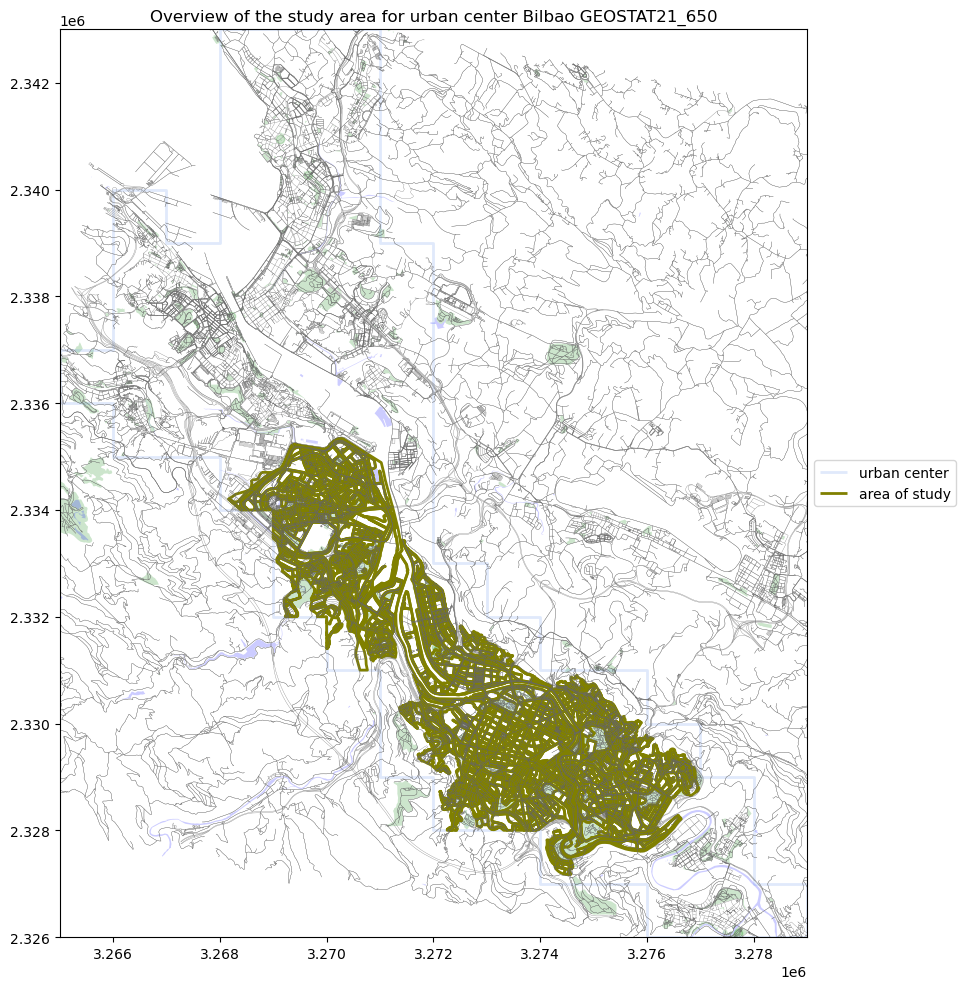

In [73]:

# Create a plot
fig, ax = plt.subplots(figsize=(10, 10))
osm_edges3035 = osm_edges.to_crs(epsg=3035)
parks3035 = parks.to_crs(epsg=3035)
osm_edges3035 = osm_edges.to_crs(epsg=3035)
water3035 = water.to_crs(epsg=3035)
# Plot the coastlines
coastline3035 =coastlines.to_crs(epsg=3035)

bbox = urban_center.total_bounds
north, south, east, west = bbox[3], bbox[1], bbox[2], bbox[0]

# Plot GeoDataFrames with boundary data
urban_center.boundary.plot(ax=ax, color= 'cornflowerblue', edgecolor='cornflowerblue',linewidth=2, alpha=1, label='urban center')
ua_urbc_agl.boundary.plot(ax=ax, color='olive',edgecolor='olive', linewidth=2, label='area of study')

# Plot the OSM street network
osm_edges3035.plot(ax=ax, linewidth=0.2, color = 'dimgrey', edgecolor='gray')

# Plot additional OSM layers
parks3035.plot(ax=ax, color='green', alpha=0.2)
water3035.plot(ax=ax, color='blue', alpha=0.2)
rivers3035.plot(ax=ax, color='blue', alpha=0.2)

# Set the plot limits to match the bounding box
ax.set_xlim(west, east)
ax.set_ylim(south, north)

# Add title and labels
ax.set_title(f'Overview of the study area for urban center {uc_name} {uc_code}')

# Add a legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust the layout to make room for the legend
plt.tight_layout()

# Show the plot
plt.show()

In [71]:
bbox = urban_center4326.total_bounds
north, south, east, west = bbox[3], bbox[1], bbox[2], bbox[0]
rivers = ox.geometries_from_bbox(north, south, east, west, tags={'waterway': 'river'})

Q:\UserTemp\ubach\AppData\Local\Temp\3\ipykernel_12536\344773735.py:3: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  rivers = ox.geometries_from_bbox(north, south, east, west, tags={'waterway': 'river'})


Q:\UserTemp\ubach\AppData\Local\Temp\3\ipykernel_12536\205762647.py:34: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


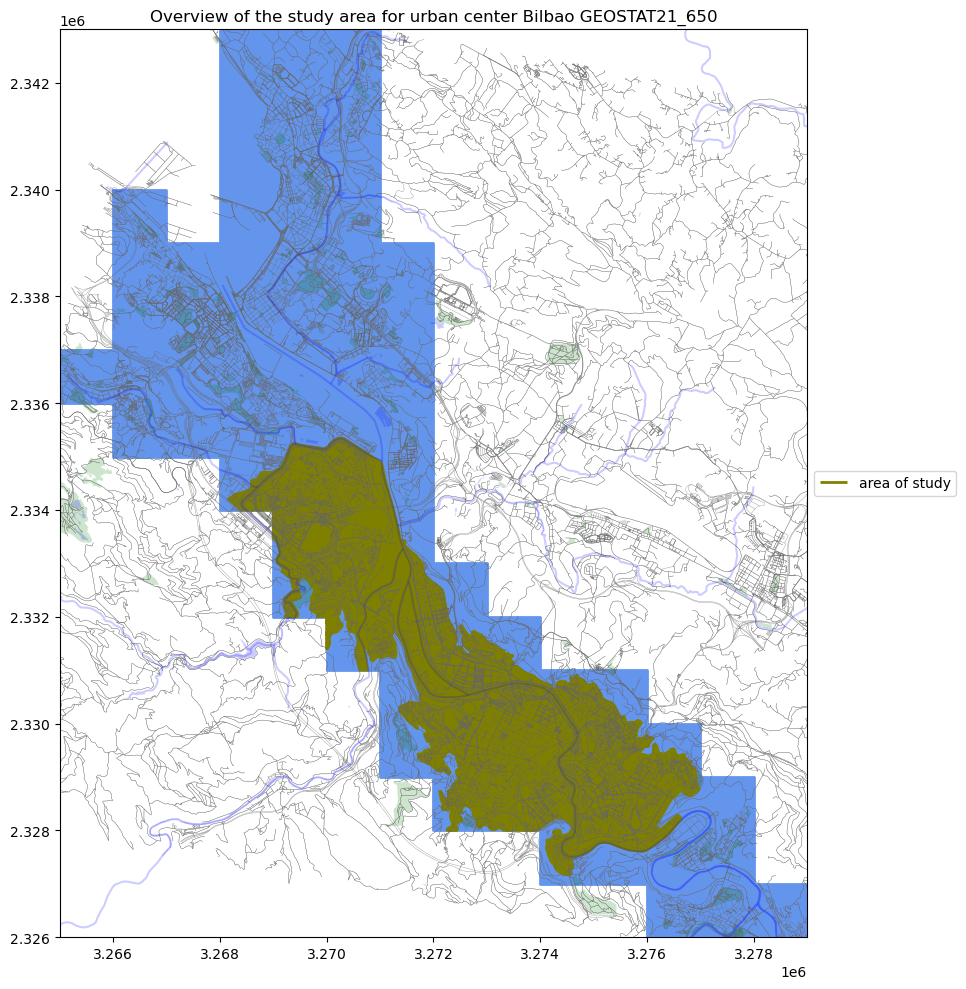

In [75]:

# Create a plot
fig, ax = plt.subplots(figsize=(10, 10))
osm_edges3035 = osm_edges.to_crs(epsg=3035)
parks3035 = parks.to_crs(epsg=3035)
osm_edges3035 = osm_edges.to_crs(epsg=3035)
water3035 = water.to_crs(epsg=3035)
rivers3035 = rivers.to_crs(epsg=3035)
# Plot the coastlines
coastline3035 =coastlines.to_crs(epsg=3035)

bbox = urban_center.total_bounds
north, south, east, west = bbox[3], bbox[1], bbox[2], bbox[0]

# Plot GeoDataFrames with boundary data
urban_center.plot(ax=ax, facecolor= 'cornflowerblue', edgecolor='cornflowerblue',linewidth=2, alpha=1, label='urban center')
ua_urbc_agl.boundary.plot(ax=ax, facecolor='olive',edgecolor='olive', linewidth=2, label='area of study')

# Plot the OSM street network
osm_edges3035.plot(ax=ax, linewidth=0.2, color = 'dimgrey', edgecolor='gray')

# Plot additional OSM layers
parks3035.plot(ax=ax, color='green', alpha=0.2)
water3035.plot(ax=ax, color='blue', alpha=0.2)
rivers3035.plot(ax=ax, color='blue', alpha=0.2)

# Set the plot limits to match the bounding box
ax.set_xlim(west, east)
ax.set_ylim(south, north)

# Add title and labels
ax.set_title(f'Overview of the study area for urban center {uc_name} {uc_code}')

# Add a legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust the layout to make room for the legend
plt.tight_layout()

# Show the plot
plt.show()

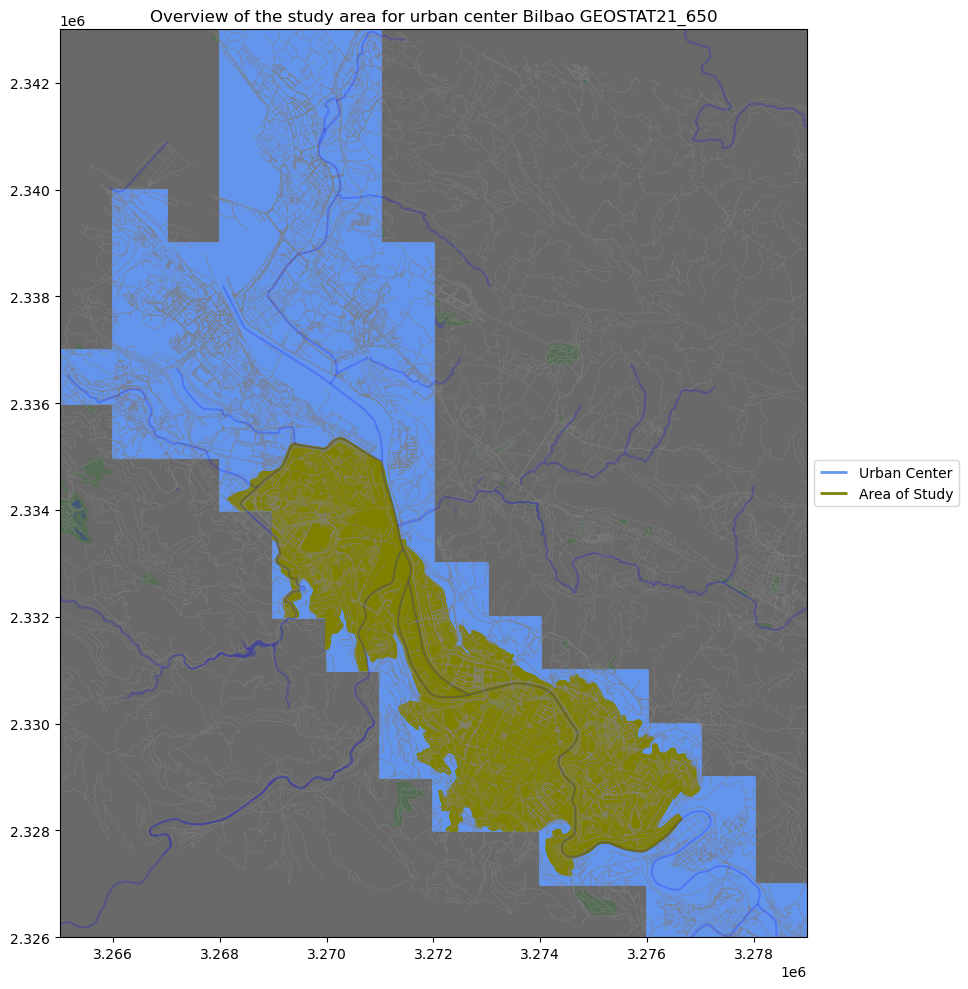

In [82]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Create a plot
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_facecolor('dimgrey')

# Reproject GeoDataFrames
osm_edges3035 = osm_edges.to_crs(epsg=3035)
parks3035 = parks.to_crs(epsg=3035)
water3035 = water.to_crs(epsg=3035)
rivers3035 = rivers.to_crs(epsg=3035)
coastline3035 = coastlines.to_crs(epsg=3035)

# Define bounding box for plot limits
bbox = urban_center.total_bounds
north, south, east, west = bbox[3], bbox[1], bbox[2], bbox[0]

# Plot GeoDataFrames with boundary data
urban_center_plot = urban_center.boundary.plot(ax=ax, facecolor='cornflowerblue', edgecolor='cornflowerblue', linewidth=2, alpha=1, label='Urban Center')
ua_urbc_agl_plot = ua_urbc_agl.boundary.plot(ax=ax, facecolor='olive', edgecolor='olive', linewidth=2, label='Area of Study')

# Plot the OSM street network
osm_edges3035.plot(ax=ax, linewidth=0.2,  edgecolor='gray')

# Plot additional OSM layers
parks3035.plot(ax=ax, color='green', alpha=0.2)
water3035.plot(ax=ax, color='blue', alpha=0.2)
rivers3035.plot(ax=ax, color='blue', alpha=0.2)  # Changed color for rivers for better visibility

# Plot coastlines
coastline3035.boundary.plot(ax=ax, edgecolor='black', linewidth=1)

# Set the plot limits to match the bounding box
ax.set_xlim(west, east)
ax.set_ylim(south, north)

# Add title and labels
ax.set_title(f'Overview of the study area for urban center {uc_name} {uc_code}')

# Add a legend
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust the layout to make room for the legend
plt.tight_layout()

# Show the plot
plt.show()


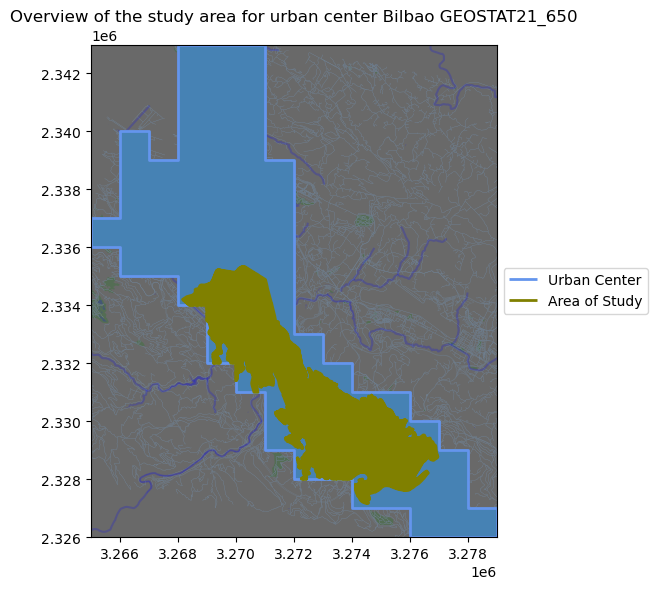

In [106]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Create a plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_facecolor('dimgrey')

# Reproject GeoDataFrames
osm_edges3035 = osm_edges.to_crs(epsg=3035)
parks3035 = parks.to_crs(epsg=3035)
water3035 = water.to_crs(epsg=3035)
rivers3035 = rivers.to_crs(epsg=3035)
coastline3035 = coastlines.to_crs(epsg=3035)

# Define bounding box for plot limits
bbox = urban_center.total_bounds
north, south, east, west = bbox[3], bbox[1], bbox[2], bbox[0]


# Plot the OSM street network
osm_edges3035.plot(ax=ax, linewidth=0.2,  edgecolor='slategrey')

# Plot additional OSM layers
parks3035.plot(ax=ax, color='green', alpha=0.2)
water3035.plot(ax=ax, color='blue', alpha=0.2)
rivers3035.plot(ax=ax, color='blue', alpha=0.2)  # Changed color for rivers for better visibility

# Plot coastlines
coastline3035.boundary.plot(ax=ax, edgecolor='black', linewidth=1)

# Plot GeoDataFrames with boundary data
urban_center_plot = urban_center.boundary.plot(ax=ax, facecolor='steelblue', edgecolor='cornflowerblue', linewidth=2, alpha=1, label='Urban Center')
ua_urbc_agl_plot = ua_urbc_agl.boundary.plot(ax=ax, facecolor='olive', edgecolor='olive', linewidth=2,  alpha=1, label='Area of Study')

# Set the plot limits to match the bounding box
ax.set_xlim(west, east)
ax.set_ylim(south, north)

# Add title and labels
ax.set_title(f'Overview of the study area for urban center {uc_name} {uc_code}')

# Add a legend
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust the layout to make room for the legend
plt.tight_layout()

# Show the plot
plt.show()

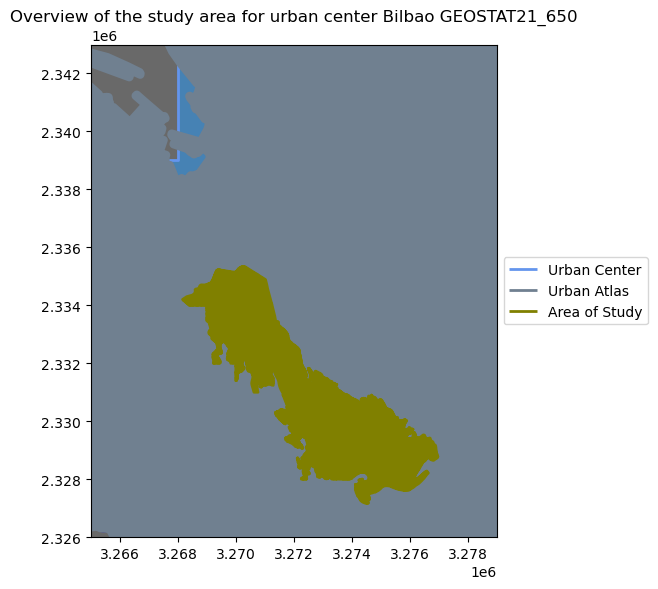

In [107]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Create a plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_facecolor('dimgrey')

# Reproject GeoDataFrames
osm_edges3035 = osm_edges.to_crs(epsg=3035)
parks3035 = parks.to_crs(epsg=3035)
water3035 = water.to_crs(epsg=3035)
rivers3035 = rivers.to_crs(epsg=3035)
coastline3035 = coastlines.to_crs(epsg=3035)

# Define bounding box for plot limits
bbox = urban_center.total_bounds
north, south, east, west = bbox[3], bbox[1], bbox[2], bbox[0]


# Plot the OSM street network
osm_edges3035.plot(ax=ax, linewidth=0.2,  edgecolor='silver')

# Plot additional OSM layers
parks3035.plot(ax=ax, color='green', alpha=0.2)
water3035.plot(ax=ax, color='blue', alpha=0.2)
rivers3035.plot(ax=ax, color='blue', alpha=0.2)  # Changed color for rivers for better visibility

# Plot coastlines
coastline3035.boundary.plot(ax=ax, edgecolor='black', linewidth=1)

# Plot GeoDataFrames with boundary data
urban_center_plot = urban_center.boundary.plot(ax=ax, facecolor='steelblue', edgecolor='cornflowerblue', linewidth=2, alpha=1, label='Urban Center')
ua_plot = ua.boundary.plot(ax=ax, facecolor='slategrey', edgecolor='slategrey', linewidth=2,  alpha=1, label='Urban Atlas')
ua_urbc_agl_plot = ua_urbc_agl.boundary.plot(ax=ax, facecolor='olive', edgecolor='olive', linewidth=2,  alpha=1, label='Area of Study')

# Set the plot limits to match the bounding box
ax.set_xlim(west, east)
ax.set_ylim(south, north)

# Add title and labels
ax.set_title(f'Overview of the study area for urban center {uc_name} {uc_code}')

# Add a legend
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust the layout to make room for the legend
plt.tight_layout()

# Show the plot
plt.show()

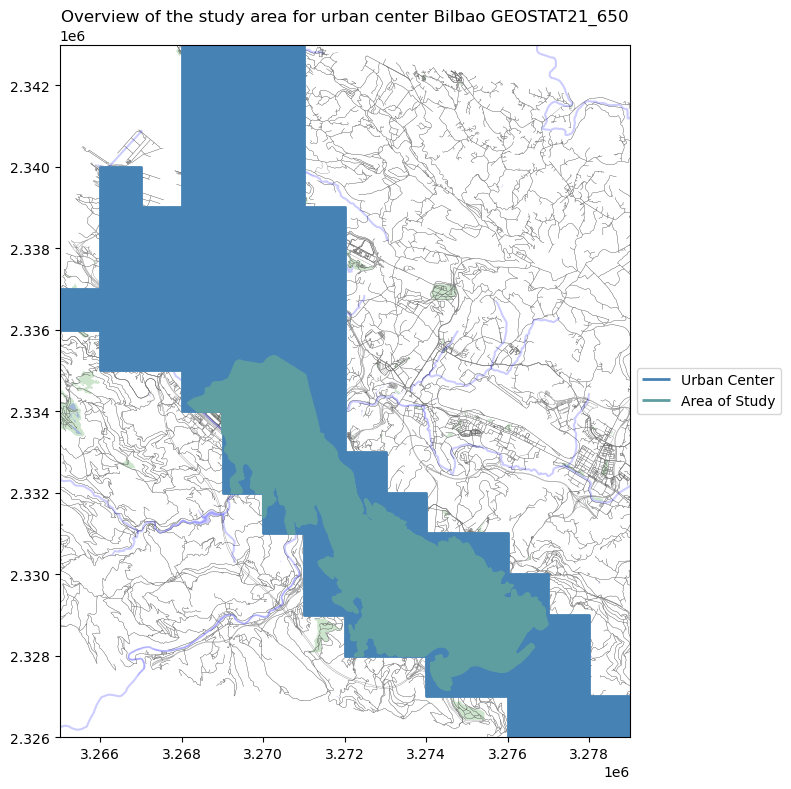

In [90]:
# Create a plot
fig, ax = plt.subplots(figsize=(8, 8))

# Reproject GeoDataFrames
osm_edges3035 = osm_edges.to_crs(epsg=3035)
parks3035 = parks.to_crs(epsg=3035)
water3035 = water.to_crs(epsg=3035)
rivers3035 = rivers.to_crs(epsg=3035)
coastline3035 = coastlines.to_crs(epsg=3035)

# Define bounding box for plot limits
bbox = urban_center.total_bounds
north, south, east, west = bbox[3], bbox[1], bbox[2], bbox[0]


# Plot the OSM street network
osm_edges3035.plot(ax=ax, linewidth=0.2,  edgecolor='dimgrey')

# Plot additional OSM layers
parks3035.plot(ax=ax, color='green', alpha=0.2)
water3035.plot(ax=ax, color='blue', alpha=0.2)
rivers3035.plot(ax=ax, color='blue', alpha=0.2)  # Changed color for rivers for better visibility

# Plot coastlines
coastline3035.boundary.plot(ax=ax, edgecolor='black', linewidth=1)

# Plot GeoDataFrames with boundary data
urban_center_plot = urban_center.boundary.plot(ax=ax, facecolor='steelblue', edgecolor='steelblue', linewidth=2, alpha=1, label='Urban Center')
ua_urbc_agl_plot = ua_urbc_agl.boundary.plot(ax=ax, facecolor='cadetblue', edgecolor='cadetblue', linewidth=2,  alpha=1, label='Area of Study')

# Set the plot limits to match the bounding box
ax.set_xlim(west, east)
ax.set_ylim(south, north)

# Add title and labels
ax.set_title(f'Overview of the study area for urban center {uc_name} {uc_code}')

# Add a legend
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust the layout to make room for the legend
plt.tight_layout()

# Show the plot
plt.show()

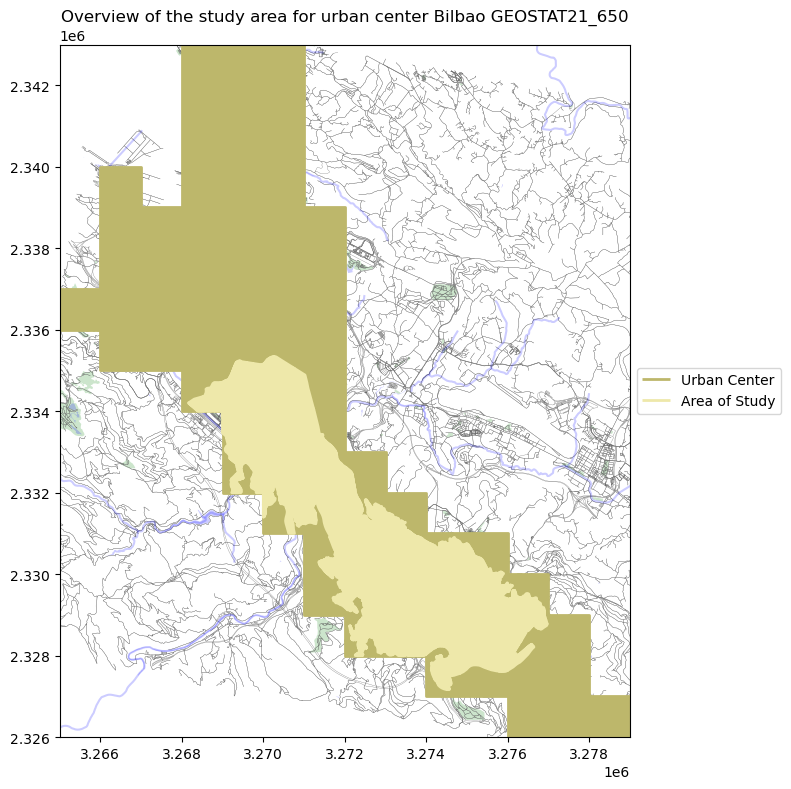

In [93]:
# Create a plot
fig, ax = plt.subplots(figsize=(8, 8))

# Reproject GeoDataFrames
osm_edges3035 = osm_edges.to_crs(epsg=3035)
parks3035 = parks.to_crs(epsg=3035)
water3035 = water.to_crs(epsg=3035)
rivers3035 = rivers.to_crs(epsg=3035)
coastline3035 = coastlines.to_crs(epsg=3035)

# Define bounding box for plot limits
bbox = urban_center.total_bounds
north, south, east, west = bbox[3], bbox[1], bbox[2], bbox[0]


# Plot the OSM street network
osm_edges3035.plot(ax=ax, linewidth=0.2,  edgecolor='dimgrey')

# Plot additional OSM layers
parks3035.plot(ax=ax, color='green', alpha=0.2)
water3035.plot(ax=ax, color='blue', alpha=0.2)
rivers3035.plot(ax=ax, color='blue', alpha=0.2)  # Changed color for rivers for better visibility

# Plot coastlines
coastline3035.boundary.plot(ax=ax, edgecolor='black', linewidth=1)

# Plot GeoDataFrames with boundary data
urban_center_plot = urban_center.boundary.plot(ax=ax, facecolor='darkkhaki', edgecolor='darkkhaki', linewidth=2, alpha=1, label='Urban Center')
ua_urbc_agl_plot = ua_urbc_agl.boundary.plot(ax=ax, facecolor='palegoldenrod', edgecolor='palegoldenrod', linewidth=2,  alpha=1, label='Area of Study')

# Set the plot limits to match the bounding box
ax.set_xlim(west, east)
ax.set_ylim(south, north)

# Add title and labels
ax.set_title(f'Overview of the study area for urban center {uc_name} {uc_code}')

# Add a legend
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust the layout to make room for the legend
plt.tight_layout()

# Show the plot
plt.show()

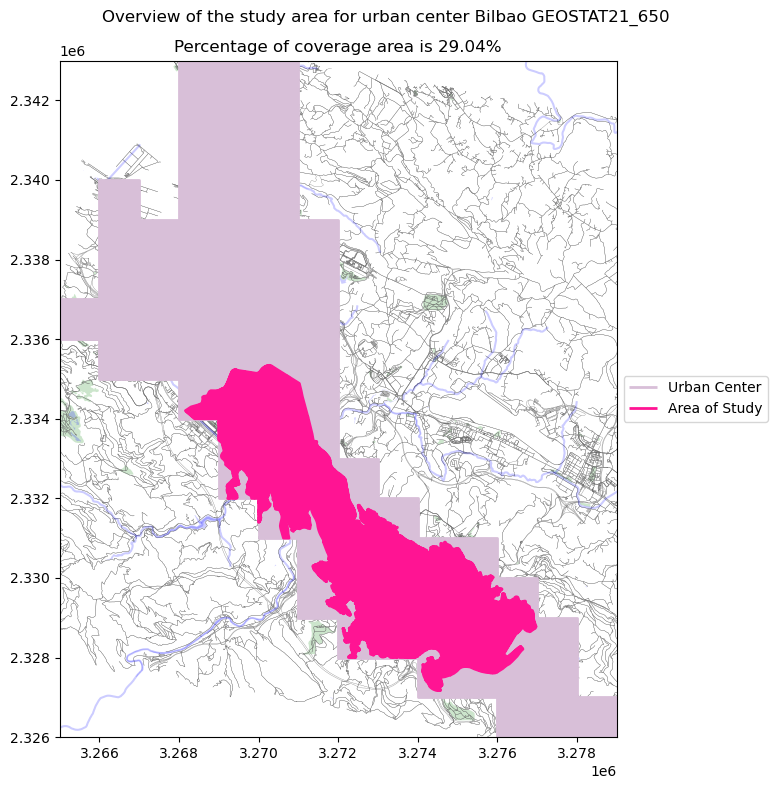

In [104]:
# Create a plot
fig, ax = plt.subplots(figsize=(8, 8))

# Reproject GeoDataFrames
osm_edges3035 = osm_edges.to_crs(epsg=3035)
parks3035 = parks.to_crs(epsg=3035)
water3035 = water.to_crs(epsg=3035)
rivers3035 = rivers.to_crs(epsg=3035)
coastline3035 = coastlines.to_crs(epsg=3035)

# Define bounding box for plot limits
bbox = urban_center.total_bounds
north, south, east, west = bbox[3], bbox[1], bbox[2], bbox[0]


# Plot the OSM street network
osm_edges3035.plot(ax=ax, linewidth=0.2,  edgecolor='dimgrey')

# Plot additional OSM layers
parks3035.plot(ax=ax, color='green', alpha=0.2)
water3035.plot(ax=ax, color='blue', alpha=0.2)
rivers3035.plot(ax=ax, color='blue', alpha=0.2)  # Changed color for rivers for better visibility

# Plot coastlines
coastline3035.boundary.plot(ax=ax, edgecolor='black', linewidth=1)

# Plot GeoDataFrames with boundary data
urban_center_plot = urban_center.boundary.plot(ax=ax, facecolor='thistle', edgecolor='thistle', linewidth=2, alpha=1, label='Urban Center')
ua_urbc_agl_plot = ua_urbc_agl.boundary.plot(ax=ax, facecolor='deeppink', edgecolor='deeppink', linewidth=2,  alpha=1, label='Area of Study')

# Set the plot limits to match the bounding box
ax.set_xlim(west, east)
ax.set_ylim(south, north)

# Add title and labels
plt.suptitle(f'Overview of the study area for urban center {uc_name} {uc_code}')
perc_Cov = totals.query(f'uc_code=="{uc_code}"').Perc_coverage_Area.values[0]
ax.set_title(f'Percentage of coverage area is {perc_Cov}%')
##ax.text(0.5, 1.1, f'Percentage of coverage area is {perc_Cov}%', ha='center', va='bottom', transform=ax.transAxes, fontsize=12, color='black')

# Add a legend
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust the layout to make room for the legend
plt.tight_layout()

# Show the plot
plt.show()

In [95]:
perc_Cov = totals.query(f'uc_code=="{uc_code}"').Perc_coverage_Area.values[0]

In [96]:
perc_Cov

29.04

In [6]:
csv_name1 = 'GQA_v2024_0708.csv'
csv_path1 = os.path.join(outdata_f, csv_name1)
out_tbl1 = pd.read_csv(csv_path1)

In [16]:
out_tbl2

uc_code                uc_name ctry_code  TotalUCAreaHa  \
0   GEOSTAT21_022                 Örebro        SE         2700.0   
1   GEOSTAT21_914  Jönköping / Huskvarna        SE         2400.0   
2   GEOSTAT21_026                  Borås        SE         2400.0   
3   GEOSTAT21_070                 Elbląg        PL         1600.0   
4   GEOSTAT21_086                   Kiel        DE         6400.0   
5   GEOSTAT21_090                Olsztyn        PL         2900.0   
6   GEOSTAT21_093           Lütten Klein        DE         1200.0   
7   GEOSTAT21_094                Rostock        DE         3100.0   
8   GEOSTAT21_108                 Lübeck        DE         5700.0   
9   GEOSTAT21_120               Szczecin        PL         5200.0   
10  GEOSTAT21_122            Kasztelanka        PL          900.0   
11  GEOSTAT21_128              Bydgoszcz        PL         4600.0   
12  GEOSTAT21_131                  Toruń        PL         3300.0   
13  GEOSTAT21_154                  Płock        PL         1100.0   
14  GEOSTAT21_161    Gorzów Wielkopolski        PL         1900.0   
15  GEOSTAT21_003                   Umeå        SE         3600.0   
16  GEOSTAT21_911                  Lahti        FI         2200.0   
17  GEOSTAT21_016               Västerås        SE         4000.0   
18  GEOSTAT21_199                Hengelo        NL         2200.0   
19  GEOSTAT21_203              Apeldoorn        NL         3600.0   
20  GEOSTAT21_208               Enschede        NL         3100.0   
21  GEOSTAT21_229                   Łódź        PL        11100.0   
22  GEOSTAT21_220                  Gouda        NL         1700.0   
23  GEOSTAT21_223             Hildesheim        DE         1500.0   
24  GEOSTAT21_239                 Arnhem        NL         5200.0   
25  GEOSTAT21_237              Bielefeld        DE         5400.0   
26  GEOSTAT21_249                  Radom        PL         3800.0   
27  GEOSTAT21_256               Nijmegen        NL         4000.0   
28  GEOSTAT21_331        Mönchengladbach        DE         5600.0   
29  GEOSTAT21_335            Częstochowa        PL         3700.0   
30  GEOSTAT21_339                Dresden        DE        12100.0   
31  GEOSTAT21_359               Chemnitz        DE         4100.0   
32  GEOSTAT21_366                Rzeszów        PL         3800.0   
33  GEOSTAT21_289              Göttingen        DE         2600.0   
34  GEOSTAT21_295     Halle an der Saale        DE         4700.0   
35  GEOSTAT21_312                Leipzig        DE        14000.0   
36  GEOSTAT21_308                 Kielce        PL         2700.0   
37  GEOSTAT21_168                Alkmaar        NL         2300.0   
38  GEOSTAT21_188                Potsdam        DE         3800.0   
39  GEOSTAT21_405              Wiesbaden        DE         4300.0   
40  GEOSTAT21_408                  Mainz        DE         5600.0   
41  GEOSTAT21_417               Würzburg        DE         3300.0   
42  GEOSTAT21_421               Erlangen        DE         3300.0   
43  GEOSTAT21_907               Augsburg        DE         8300.0   

    TotalGreenAreaHa  green_excludedHa  TotalGreenQuietAreaHa  \
0             569.89             -0.00                 139.15   
1             528.42              0.00                 354.01   
2             563.43              0.00                 315.34   
3             144.42              0.56                  70.60   
4             814.23            165.59                 261.42   
5             514.38             14.12                 436.00   
6             132.41              0.00                  47.90   
7             275.40              0.21                 183.65   
8             472.03            109.44                 161.18   
9             638.19              0.01                 383.97   
10            102.35              1.40                  35.67   
11            921.06            266.30                 235.56   
12            744.45              0.00                 495.

In [15]:
out_tbl1

uc_code                uc_name ctry_code  TotalUCAreaHa  \
0   GEOSTAT21_905                Utrecht        NL         5800.0   
1   GEOSTAT21_904                 Dublin        IE        32700.0   
2   GEOSTAT21_903              København        DK        29900.0   
3   GEOSTAT21_901               Helsinki        FI        33300.0   
4   GEOSTAT21_856                Lemesos        CY         4600.0   
..            ...                    ...       ...            ...   
82  GEOSTAT21_441              Heilbronn        DE         2400.0   
83  GEOSTAT21_428             Heidelberg        DE         3100.0   
84  GEOSTAT21_429                  Fürth        DE        13600.0   
85  GEOSTAT21_425  Mannheim/Ludwigshafen        DE        11200.0   
86  GEOSTAT21_489                 Angers        FR         5400.0   

    TotalGreenAreaHa  green_excludedHa  TotalGreenQuietAreaHa  \
0             566.74              9.53                 240.73   
1            3593.16              9.41                1829.20   
2            3344.86            307.60                1620.82   
3            8728.36           4394.20                 150.00   
4              83.37              1.77                  18.24   
..               ...               ...                    ...   
82            122.19              7.40                  88.28   
83            630.16              0.10                 519.19   
84           1708.89            786.88                 585.43   
85            844.61            463.43                 371.89   
86            636.34              0.00                 133.78   

    PercGreenQuietArea  weighted_median_Ha  TotalGQAPop  TotalPop  
0            43.202742               90.11       151051    364839  
1            51.041507               91.57       485270   1298274  
2            53.364546               98.44       294470   1100122  
3             3.460878               88.85         9771   1102678  
4            22.352941               32.51         6205    165982  
..                 ...                 ...          ...       ...  
82           76.905654               62.20        22672    106102  
83           82.403263               92.96        39088    145844  
84           63.494973               71.54       196958    666010  
85           97.562831               67.72       100969    503807  
86           21.023352               43.16        26998    204378  

[87 rows x 11 columns]

In [17]:
out_tbl1 = pd.read_csv(csv_path1)
out_tbl2 = pd.read_csv(csv_path)
result_tbl = pd.concat([out_tbl1, out_tbl2], ignore_index=True)
result_tbl

uc_code    uc_name ctry_code  TotalUCAreaHa  TotalGreenAreaHa  \
0    GEOSTAT21_905    Utrecht        NL         5800.0            566.74   
1    GEOSTAT21_904     Dublin        IE        32700.0           3593.16   
2    GEOSTAT21_903  København        DK        29900.0           3344.86   
3    GEOSTAT21_901   Helsinki        FI        33300.0           8728.36   
4    GEOSTAT21_856    Lemesos        CY         4600.0             83.37   
..             ...        ...       ...            ...               ...   
259  GEOSTAT21_856    Lemesos        CY         4600.0             83.37   
260  GEOSTAT21_901   Helsinki        FI        33300.0           8728.36   
261  GEOSTAT21_903  København        DK        29900.0           3344.86   
262  GEOSTAT21_904     Dublin        IE        32700.0           3593.16   
263  GEOSTAT21_905    Utrecht        NL         5800.0            566.74   

     green_excludedHa  TotalGreenQuietAreaHa  PercGreenQuietArea  \
0                9.53                 240.73           43.202742   
1                9.41                1829.20           51.041507   
2              307.60                1620.82           53.364546   
3             4394.20                 150.00            3.460878   
4                1.77                  18.24           22.352941   
..                ...                    ...                 ...   
259              1.77                  18.24           22.352941   
260           4394.20                 150.00            3.460878   
261            307.60                1620.82           53.364546   
262              9.41                1829.20           51.041507   
263              9.53                 240.73           43.202742   

     weighted_median_Ha  TotalGQAPop  TotalPop  
0                 90.11       151051    364839  
1                 91.57       485270   1298274  
2                 98.44       294470   1100122  
3                 88.85         9771   1102678  
4                 32.51         6205    165982  
..                  ...          ...       ...  
259               32.51         6205    165982  
260               88.85         9771   1102678  
261               98.44       294470   1100122  
262               91.57       485270   1298274  
263               90.11       151051    364839  

[264 rows x 11 columns]

In [19]:
result_tbl = result_tbl.drop_duplicates()
result_tbl

uc_code                uc_name ctry_code  TotalUCAreaHa  \
0    GEOSTAT21_905                Utrecht        NL         5800.0   
1    GEOSTAT21_904                 Dublin        IE        32700.0   
2    GEOSTAT21_903              København        DK        29900.0   
3    GEOSTAT21_901               Helsinki        FI        33300.0   
4    GEOSTAT21_856                Lemesos        CY         4600.0   
..             ...                    ...       ...            ...   
127  GEOSTAT21_086                   Kiel        DE         6400.0   
128  GEOSTAT21_070                 Elbląg        PL         1600.0   
129  GEOSTAT21_026                  Borås        SE         2400.0   
130  GEOSTAT21_914  Jönköping / Huskvarna        SE         2400.0   
131  GEOSTAT21_022                 Örebro        SE         2700.0   

     TotalGreenAreaHa  green_excludedHa  TotalGreenQuietAreaHa  \
0              566.74              9.53                 240.73   
1             3593.16              9.41                1829.20   
2             3344.86            307.60                1620.82   
3             8728.36           4394.20                 150.00   
4               83.37              1.77                  18.24   
..                ...               ...                    ...   
127            814.23            165.59                 261.42   
128            144.42              0.56                  70.60   
129            563.43              0.00                 315.34   
130            528.42              0.00                 354.01   
131            569.89             -0.00                 139.15   

     PercGreenQuietArea  weighted_median_Ha  TotalGQAPop  TotalPop  
0             43.202742               90.11       151051    364839  
1             51.041507               91.57       485270   1298274  
2             53.364546               98.44       294470   1100122  
3              3.460878               88.85         9771   1102678  
4             22.352941               32.51         6205    165982  
..                  ...                 ...          ...       ...  
127           40.302787               65.10        74141    255723  
128           49.075490               29.00        19422    115951  
129           55.967911               65.28        26132     70691  
130           66.994058               98.69        33655     75503  
131           24.416993               88.22        22015    103860  

[132 rows x 11 columns]

In [21]:
result_tbl.query('PercGreenQuietArea>100')

uc_code    uc_name ctry_code  TotalUCAreaHa  TotalGreenAreaHa  \
6   GEOSTAT21_706      Porto        PT        22800.0           3025.16   
64  GEOSTAT21_018  Stockholm        SE        34200.0           8327.01   

    green_excludedHa  TotalGreenQuietAreaHa  PercGreenQuietArea  \
6            2775.33                 381.26          152.607773   
64           7894.55                3186.50          736.831152   

    weighted_median_Ha  TotalGQAPop  TotalPop  
6                76.00       137124    940515  
64              134.09       791971   1635477

In [23]:
8327.01-5456.92

2870.09

In [22]:
3186.5/5456.92*100

58.39374592260835

In [12]:
## green_excluded = TotalGreenArea - TotalGreen_urbc_ncm
## TotalGreen_urbc_ncm = TotalGreenArea - green_excluded
TotalGreen_urbc_ncmHa = 3025.16 - 2775.33

In [13]:
green_excluded= 2775.33*10000

In [11]:
3025.16-2775.33

249.82999999999993

In [10]:
GQA in uc / (TotalGreen - excluded)
(381.26/(3025.16-2775.33))*100

152.6077732858344

In [28]:
result_tbl.columns

Index(['uc_code', 'uc_name', 'ctry_code', 'TotalUCAreaHa', 'TotalGreenAreaHa',
       'green_excludedHa', 'TotalGreenQuietAreaHa', 'PercGreenQuietArea',
       'weighted_median_Ha', 'TotalGQAPop', 'TotalPop'],
      dtype='object')

In [32]:
result_tbl = result_tbl.drop_duplicates()

In [175]:
result_tbl = totals.drop_duplicates()

In [162]:
result_tbl

uc_code                uc_name ctry_code  TotalUCAreaHa  \
0    GEOSTAT21_022                 Örebro        SE         2700.0   
1    GEOSTAT21_914  Jönköping / Huskvarna        SE         2400.0   
2    GEOSTAT21_026                  Borås        SE         2400.0   
3    GEOSTAT21_070                 Elbląg        PL         1600.0   
4    GEOSTAT21_086                   Kiel        DE         6400.0   
..             ...                    ...       ...            ...   
131  GEOSTAT21_047                  Århus        DK         7200.0   
132  GEOSTAT21_479                   Linz        AT         5300.0   
133  GEOSTAT21_476            Ulm/Neu-Ulm        DE         3900.0   
134  GEOSTAT21_473             Reutlingen        DE         3400.0   
137  GEOSTAT21_031                Aalborg        DK         4800.0   

     UC_UA_AreaHa  UC_UA_Pop  UC_UA_NCM_AreaHa  UC_UA_NCM_Pop  \
0         2700.00      96771           2700.00          96771   
1         2400.00      70478           2400.00          70478   
2         2400.00      67212           2400.00          67212   
3         1600.00     113020           1586.44         113002   
4         6179.77     223906           5121.94         205100   
..            ...        ...               ...            ...   
131       7050.88     236392           6737.83         236136   
132       5300.00     213219           5252.58         211008   
133       3900.00     137213           2116.42          87093   
134       3400.00     111373           2833.83          94982   
137       4566.21     127272           4470.50         127234   

     Perc_coverage_Area  Perc_coverage_Pop  TotalGreen_urbc_ncm_Ha  \
0                100.00             100.00                  569.89   
1                100.00             100.00                  528.42   
2                100.00             100.00                  563.43   
3                 99.15              99.98                  143.86   
4                 80.03              91.60                  648.64   
..                  ...                ...                     ...   
131               93.58              99.89                  813.64   
132               99.11              98.96                  604.48   
133               54.27              63.47                  344.82   
134               83.35              85.28                  163.28   
137               93.14              99.97                  535.51   

     TotalGreenQuietAreaHa  TotalGQAPop  PercGreenQuietArea  \
0                   139.15        22015           24.416993   
1                   354.01        33655           66.994058   
2                   315.34        26132           55.967911   
3                    70.60        19422           49.075490   
4                   261.42        74141           40.302787   
..                     ...          ...                 ...   
131                 603.47        99944           74.169166   
132                 379.14        91220           62.721678   
133                 204.33        40502           59.257004   
134                  91.39        20241           55.971338   
137                 347.10        52362           64.816717   

     PercGreenQuietPop  weighted_median_Ha  TotalGreenAreaHa  green_excludedHa  
0            22.749584               88.22            569.89              0.00  
1            47.752490               98.69            528.42              0.00  
2            38.879962               65.28            563.43              0.00  
3            17.187306               29.00            144.42              0.56  
4            36.148708               65.10            814.23            165.59  
..                 ...                 ...               ...               ...  
131          42.324762              107.01            852.89             39.25  
132          43.230588               72.32            604.59              0.11  
133          46.504311               82.48            476.14  

In [176]:
csv_name_result = 'GQA_v2024_0909_for_dashboard.csv'
csv_name_result = os.path.join(outdata_f, csv_name_result)
result_tbl.to_csv(csv_name_result, index=False)

In [10]:
if os.path.exists(csv_path1): 
    outtbl = pd.read_csv(csv_path1)
    cities_ls = outtbl.uc_code.to_list()
else:
    cities_ls = []

SA_ls = glob.glob(os.path.join(step2_f, '*.shp'))
uc_ls = [] 
# Print the list of shapefiles
for sa_name in SA_ls:
    uc_code = os.path.basename(sa_name)[:-7]
    if uc_code not in cities_ls:
        uc_ls.append(uc_code)

In [12]:
len(cities_ls)

36

In [11]:
len(uc_ls)

97

In [13]:
SA_ls = glob.glob(os.path.join(step2_f, '*.shp'))

In [15]:
SA_ls[:10]

['P:\\Environment and Health\\Noise\\ServiceContract\\2024_ServiceContract\\QuietAreas\\OutputData\\SA\\GEOSTAT21_905_SA.shp',
 'P:\\Environment and Health\\Noise\\ServiceContract\\2024_ServiceContract\\QuietAreas\\OutputData\\SA\\GEOSTAT21_904_SA.shp',
 'P:\\Environment and Health\\Noise\\ServiceContract\\2024_ServiceContract\\QuietAreas\\OutputData\\SA\\GEOSTAT21_903_SA.shp',
 'P:\\Environment and Health\\Noise\\ServiceContract\\2024_ServiceContract\\QuietAreas\\OutputData\\SA\\GEOSTAT21_901_SA.shp',
 'P:\\Environment and Health\\Noise\\ServiceContract\\2024_ServiceContract\\QuietAreas\\OutputData\\SA\\GEOSTAT21_856_SA.shp',
 'P:\\Environment and Health\\Noise\\ServiceContract\\2024_ServiceContract\\QuietAreas\\OutputData\\SA\\GEOSTAT21_843_SA.shp',
 'P:\\Environment and Health\\Noise\\ServiceContract\\2024_ServiceContract\\QuietAreas\\OutputData\\SA\\GEOSTAT21_706_SA.shp',
 'P:\\Environment and Health\\Noise\\ServiceContract\\2024_ServiceContract\\QuietAreas\\OutputData\\SA\\GEOSTAT

In [16]:
SA_ls.reverse()

In [17]:
SA_ls[:10]

['P:\\Environment and Health\\Noise\\ServiceContract\\2024_ServiceContract\\QuietAreas\\OutputData\\SA\\GEOSTAT21_022_SA.shp',
 'P:\\Environment and Health\\Noise\\ServiceContract\\2024_ServiceContract\\QuietAreas\\OutputData\\SA\\GEOSTAT21_914_SA.shp',
 'P:\\Environment and Health\\Noise\\ServiceContract\\2024_ServiceContract\\QuietAreas\\OutputData\\SA\\GEOSTAT21_026_SA.shp',
 'P:\\Environment and Health\\Noise\\ServiceContract\\2024_ServiceContract\\QuietAreas\\OutputData\\SA\\GEOSTAT21_070_SA.shp',
 'P:\\Environment and Health\\Noise\\ServiceContract\\2024_ServiceContract\\QuietAreas\\OutputData\\SA\\GEOSTAT21_086_SA.shp',
 'P:\\Environment and Health\\Noise\\ServiceContract\\2024_ServiceContract\\QuietAreas\\OutputData\\SA\\GEOSTAT21_090_SA.shp',
 'P:\\Environment and Health\\Noise\\ServiceContract\\2024_ServiceContract\\QuietAreas\\OutputData\\SA\\GEOSTAT21_093_SA.shp',
 'P:\\Environment and Health\\Noise\\ServiceContract\\2024_ServiceContract\\QuietAreas\\OutputData\\SA\\GEOSTAT

# All together

In [18]:
if os.path.exists(csv_path): 
    outtbl = pd.read_csv(csv_path)
    cities_ls = outtbl.uc_code.to_list()
else:
    cities_ls = []

SA_ls = glob.glob(os.path.join(step2_f, '*.shp'))
SA_ls.reverse()

# Print the list of shapefiles
for sa_name in SA_ls:
    uc_code = os.path.basename(sa_name)[:-7]
    if uc_code not in cities_ls:
        SA = gpd.read_file(sa_name)
        SA.loc[:, 'FID_GQA'] = SA['Name'].str.split(":").str[0]
        uc_name = codes.query(f'HDENS_CLST=="{uc_code}"').HDENS_NAME.values[0]
        print(f'{uc_name} {uc_code}')
        print(str(datetime.now()))
        
        # Dissolve by GQA identifier 
        file_path = os.path.join(outdata_f, f'{uc_code}_SA_FID_dis.shp')
        if not os.path.exists(file_path):
            SA_FID_dis = SA.dissolve('FID_GQA')
            SA_FID_dis.reset_index(inplace=True)
            SA_FID_dis.to_file(file_path, driver='ESRI Shapefile')

        # Erase those areas of SA overlapping the GUAs
        # Load QGA
        path = os.path.join(path2FinalGQA, f'{uc_code}_finalGQA.shp')
        GQA = gpd.read_file(path)

        # Remove QGA delineation from the SA
        file_path = os.path.join(outdata_f, f'{uc_code}_SA_final.shp')
        if not os.path.exists(file_path):
            SA_final = gpd.overlay(SA_FID_dis, GQA, how='difference')
            SA_final.to_file(file_path, driver='ESRI Shapefile')
        
        else:
            SA_final = gpd.read_file(file_path)

        #### Calculate the portion of SA that intersect between each other (SA_final)
        #########################################################################################
        # Some polygons from the service areas are intersecting with other service areas 
        # generated from different GQAs. This meaning some polygons overlap where different SA 
        # coincide. To properly assign the amount of qreen quiet area with accessibility, 
        # we need to differentiate these areas & sum the number of areas from the different GQA 
        # that serves.

        ## Creating non-overlapping units following the proposed approach from:
        ## https://gis.stackexchange.com/questions/187402/how-to-find-the-intersection-areas-of-overlapping-buffer-zones-in-single-shapefi/187499#187499

        # select a subset of columns
        SA_final = SA_final[['FID_GQA','geometry']]
        SA_final['area_m2'] = SA_final.geometry.area

        # Split multipart polygons to single part polygons
        SA_FID_mp = SA_final.explode(ignore_index=True)

        # create unique features from input polygons
        rings = [LineString(list(shape(geometry).exterior.coords)) for geometry in SA_FID_mp['geometry']]
        union = unary_union(rings)
        SA_no_overlaps = [geom for geom in polygonize(union)]

        # Create a new GeoDataFrame for the result
        file_path = os.path.join(outdata_f,  f'{uc_code}_SA_no_overlaps.shp')
        if not os.path.exists(file_path):
            SA_no_overlaps_gdf = gpd.GeoDataFrame(geometry=SA_no_overlaps)

            # Add an 'area' column to the new GeoDataFrame
            SA_no_overlaps_gdf['area'] = SA_no_overlaps_gdf['geometry'].area
            SA_no_overlaps_gdf.crs = SA_FID_mp.crs

            # remove again the GQA
            SA_no_overlaps_gdf = gpd.overlay(SA_no_overlaps_gdf, GQA, how='difference')

            # Add unique id field
            SA_no_overlaps_gdf['unique_id'] = range(len(SA_no_overlaps_gdf))

            # Save the result GeoDataFrame to shapefile
            SA_no_overlaps_gdf.to_file(file_path, driver='ESRI Shapefile')
        
        else:
            SA_no_overlaps_gdf = gpd.read_file(file_path)

        result_erase_FIDs_left = gpd.sjoin(SA_no_overlaps_gdf, SA_final, how= 'left', op='intersects')
        SA_GQA_total = result_erase_FIDs_left.dissolve(by='unique_id', aggfunc={'area_m2': 'sum', 'FID_GQA': ['count', 'first']})
        SA_GQA_total.reset_index(inplace=True)
        SA_GQA_total.columns = ['unique_id', 'geometry', 'total_area_m2', 'FID_GQA_count', 'FID_GQA_first']

        # Load urban center
        urban_center = urban_centers.query(f'HDENS_CLST=="{uc_code}"')
        TotalUCArea = urban_center.geometry.area.sum()
        TotalUCAreaHa = round(TotalUCArea/10000,2)  

        # Remove the outer areas from urban centers      
        file_path = os.path.join(outdata_f, f'{uc_code}_SA_GQA_urbc.shp')
        if not os.path.exists(file_path):
            # Remove GQA delineation from the SA
            SA_GQA_urbc = gpd.overlay(SA_GQA_total, urban_center, how='intersection')
            SA_GQA_urbc.to_file(file_path, driver='ESRI Shapefile')     
        else:
            SA_GQA_urbc = gpd.read_file(file_path)

        #### Final computations including population
        ## Compute Total Green Areas
        # Read Urban Atlas data
        ua_path = codes.query(f'HDENS_CLST=="{uc_code}"').UA2018.values[0].strip()
        file_path = os.path.join(ua_data_f, f'{ua_path}\Data\{ua_path}.gpkg')
        # Read the GeoPackage file
        ua = gpd.read_file(file_path, layer= ua_path[:-5], 
                    columns= ['code_2018','Pop2018','geometry'], engine='pyogrio', 
                    use_arrow=True, bbox= tuple(urban_center.total_bounds))
        TotalPop = int(ua.Pop2018.sum())
        # urban green
        uagreen = ua.query('code_2018 == "14100" or code_2018 == "31000"')
        # urban green within the Urban Center
        uagreen_urbc = gpd.overlay(uagreen, urban_center, how='intersection')
        
        # All green areas (GUAs and forests) in the urban center (including data outside the ncm)
        TotalGreenArea = uagreen_urbc.geometry.area.sum()
        TotalGreenAreaHa = round(TotalGreenArea/10000,2)

        ## Green areas excluded (areas not covered by ncm)
        # Load the delineation for the agglomeration
        ctry_code = urban_centers.query(f'HDENS_CLST=="{uc_code}"').CNTR_CODE.values[0]
        layerName = f'dbo.DF48_agg_NoiseContours_roadsInAgglomeration_Lden_Valid_LatestDelivery_Poly_{ctry_code}'           
        ncm = gpd.read_file(ncm_file_path, layer=layerName, columns=['category', 'geometry'], 
                            engine='pyogrio', use_arrow=True, bbox= tuple(urban_center.total_bounds))

        # select agglomeration
        agl_id = codes.query(f'HDENS_CLST=="{uc_code}"').agglomerationId_identifier.values[0]
        agl_city = agls.query(f'agglomerationId_identifier == "{agl_id}"')

        # Select green areas within the noise contour maps covered by noise data
        uagreen_urbc_agl = gpd.overlay(uagreen_urbc, agl_city, how='intersection')

        # Excluded areas = TotalGreen in the urban center - TotalGreen in the uc & ncm 
        TotalGreen_urbc_ncm = uagreen_urbc_agl.area.sum()
        green_excluded = TotalGreenArea - TotalGreen_urbc_ncm
        green_excludedHa = round(green_excluded/10000,2)
        
        # Total Green Quiet Areas
        TotalGreenQuietAreaHa = round(GQA.area.sum()/10000,2)

        # Percentage of Green Quiet Areas
        ## Computed as:
        ## % of green quiet areas =  TotalGQA/(TotalGreenAreas-Green excluded) * 100
        PercGreenQuietArea = TotalGreenQuietAreaHa/(TotalGreenAreaHa-green_excludedHa)*100

        # Computing Population
        ua['original_area_m2'] = round(ua.geometry.area,2)
        SA_GQA_ua = gpd.overlay(SA_GQA_urbc,ua,how='intersection')  
        if not SA_GQA_ua.empty:  
            SA_GQA_ua = SA_GQA_ua[['unique_id', 'total_area_m2','code_2018', 'Pop2018','original_area_m2', 'geometry']]
            SA_GQA_ua['final_area_m2'] = round(SA_GQA_ua.geometry.area,2)
            SA_GQA_ua['area_prop'] = SA_GQA_ua['final_area_m2']/SA_GQA_ua['original_area_m2'] # capture proportion from original geometry
            SA_GQA_ua['Pop2018_poly'] = SA_GQA_ua['Pop2018']*SA_GQA_ua['area_prop']
            SA_GQA_ua['Pop2018_final'] = round(SA_GQA_ua.Pop2018_poly,0)
            TotalGQAPop = int(SA_GQA_ua.Pop2018_final.sum())

            # compute the weighted median for the area
            column_to_compute_median = 'total_area_m2'
            weighted_median_m2 = np.average(SA_GQA_ua[column_to_compute_median], weights=SA_GQA_ua['Pop2018_poly'])
            weighted_median_Ha = round(weighted_median_m2/10000,2)

            # Write values to output table
            log_entry = create_log_entry(uc_code, uc_name, ctry_code, TotalUCAreaHa, TotalGreenAreaHa,
                                        green_excludedHa, TotalGreenQuietAreaHa, PercGreenQuietArea,
                                        weighted_median_Ha, TotalGQAPop, TotalPop)
            write_log(csv_path, log_entry)

    


Örebro GEOSTAT21_022
2024-09-09 12:20:26.206438


Q:\UserTemp\ubach\AppData\Local\Temp\22\ipykernel_11860\3586572880.py:74: UserWarning: `keep_geom_type=True` in overlay resulted in 8 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  SA_no_overlaps_gdf = gpd.overlay(SA_no_overlaps_gdf, GQA, how='difference')
c:\Users\ubach\.conda\envs\geospatial_ETC_DI_v4\lib\site-packages\IPython\core\interactiveshell.py:3382: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
Q:\UserTemp\ubach\AppData\Local\Temp\22\ipykernel_11860\3586572880.py:100: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  SA_GQA_urbc.to_file(file_path, driver='ESRI Shapefile')
Q:\UserTemp\ubach\AppData\Local\Temp\22\ipykernel_11860\3586572880.py:152: UserWarning: `keep_geom_type=True` in overlay resulted in 143 dropped geome

Jönköping / Huskvarna GEOSTAT21_914
2024-09-09 12:24:03.443962


Q:\UserTemp\ubach\AppData\Local\Temp\22\ipykernel_11860\3586572880.py:74: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  SA_no_overlaps_gdf = gpd.overlay(SA_no_overlaps_gdf, GQA, how='difference')
c:\Users\ubach\.conda\envs\geospatial_ETC_DI_v4\lib\site-packages\IPython\core\interactiveshell.py:3382: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
Q:\UserTemp\ubach\AppData\Local\Temp\22\ipykernel_11860\3586572880.py:99: UserWarning: `keep_geom_type=True` in overlay resulted in 43 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  SA_GQA_urbc = gpd.overlay(SA_GQA_total, urban_center, how='intersection')
Q:\UserTemp\ubach\AppData\Local\Temp\22\ipykernel_11860\358

Borås GEOSTAT21_026
2024-09-09 12:28:37.566355


Q:\UserTemp\ubach\AppData\Local\Temp\22\ipykernel_11860\3586572880.py:74: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  SA_no_overlaps_gdf = gpd.overlay(SA_no_overlaps_gdf, GQA, how='difference')
c:\Users\ubach\.conda\envs\geospatial_ETC_DI_v4\lib\site-packages\IPython\core\interactiveshell.py:3382: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
Q:\UserTemp\ubach\AppData\Local\Temp\22\ipykernel_11860\3586572880.py:100: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  SA_GQA_urbc.to_file(file_path, driver='ESRI Shapefile')
Q:\UserTemp\ubach\AppData\Local\Temp\22\ipykernel_11860\3586572880.py:152: UserWarning: `keep_geom_type=True` in overlay resulted in 135 dropped geome

Elbląg GEOSTAT21_070
2024-09-09 12:29:23.745909


c:\Users\ubach\.conda\envs\geospatial_ETC_DI_v4\lib\site-packages\IPython\core\interactiveshell.py:3382: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
Q:\UserTemp\ubach\AppData\Local\Temp\22\ipykernel_11860\3586572880.py:100: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  SA_GQA_urbc.to_file(file_path, driver='ESRI Shapefile')
Q:\UserTemp\ubach\AppData\Local\Temp\22\ipykernel_11860\3586572880.py:152: UserWarning: `keep_geom_type=True` in overlay resulted in 36 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  SA_GQA_ua = gpd.overlay(SA_GQA_urbc,ua,how='intersection')


Kiel GEOSTAT21_086
2024-09-09 12:29:40.792212


Q:\UserTemp\ubach\AppData\Local\Temp\22\ipykernel_11860\3586572880.py:74: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  SA_no_overlaps_gdf = gpd.overlay(SA_no_overlaps_gdf, GQA, how='difference')
c:\Users\ubach\.conda\envs\geospatial_ETC_DI_v4\lib\site-packages\IPython\core\interactiveshell.py:3382: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
Q:\UserTemp\ubach\AppData\Local\Temp\22\ipykernel_11860\3586572880.py:100: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  SA_GQA_urbc.to_file(file_path, driver='ESRI Shapefile')
Q:\UserTemp\ubach\AppData\Local\Temp\22\ipykernel_11860\3586572880.py:152: UserWarning: `keep_geom_type=True` in overlay resulted in 493 dropped geome

Olsztyn GEOSTAT21_090
2024-09-09 12:40:32.521818


Q:\UserTemp\ubach\AppData\Local\Temp\22\ipykernel_11860\3586572880.py:74: UserWarning: `keep_geom_type=True` in overlay resulted in 4 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  SA_no_overlaps_gdf = gpd.overlay(SA_no_overlaps_gdf, GQA, how='difference')
c:\Users\ubach\.conda\envs\geospatial_ETC_DI_v4\lib\site-packages\IPython\core\interactiveshell.py:3382: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
Q:\UserTemp\ubach\AppData\Local\Temp\22\ipykernel_11860\3586572880.py:99: UserWarning: `keep_geom_type=True` in overlay resulted in 5 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  SA_GQA_urbc = gpd.overlay(SA_GQA_total, urban_center, how='intersection')
Q:\UserTemp\ubach\AppData\Local\Temp\22\ipykernel_11860\3586

Lütten Klein GEOSTAT21_093
2024-09-09 12:43:11.985038


c:\Users\ubach\.conda\envs\geospatial_ETC_DI_v4\lib\site-packages\IPython\core\interactiveshell.py:3382: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
Q:\UserTemp\ubach\AppData\Local\Temp\22\ipykernel_11860\3586572880.py:99: UserWarning: `keep_geom_type=True` in overlay resulted in 4 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  SA_GQA_urbc = gpd.overlay(SA_GQA_total, urban_center, how='intersection')
Q:\UserTemp\ubach\AppData\Local\Temp\22\ipykernel_11860\3586572880.py:100: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  SA_GQA_urbc.to_file(file_path, driver='ESRI Shapefile')
Q:\UserTemp\ubach\AppData\Local\Temp\22\ipykernel_11860\3586572880.py:152: UserWarning: `keep_geom_type=True` in overlay resulted in 86 dropped geometri

Rostock GEOSTAT21_094
2024-09-09 12:43:29.626316


c:\Users\ubach\.conda\envs\geospatial_ETC_DI_v4\lib\site-packages\IPython\core\interactiveshell.py:3382: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
Q:\UserTemp\ubach\AppData\Local\Temp\22\ipykernel_11860\3586572880.py:100: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  SA_GQA_urbc.to_file(file_path, driver='ESRI Shapefile')
Q:\UserTemp\ubach\AppData\Local\Temp\22\ipykernel_11860\3586572880.py:152: UserWarning: `keep_geom_type=True` in overlay resulted in 176 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  SA_GQA_ua = gpd.overlay(SA_GQA_urbc,ua,how='intersection')


Lübeck GEOSTAT21_108
2024-09-09 12:44:10.852885


Q:\UserTemp\ubach\AppData\Local\Temp\22\ipykernel_11860\3586572880.py:74: UserWarning: `keep_geom_type=True` in overlay resulted in 13 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  SA_no_overlaps_gdf = gpd.overlay(SA_no_overlaps_gdf, GQA, how='difference')
c:\Users\ubach\.conda\envs\geospatial_ETC_DI_v4\lib\site-packages\IPython\core\interactiveshell.py:3382: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
Q:\UserTemp\ubach\AppData\Local\Temp\22\ipykernel_11860\3586572880.py:99: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  SA_GQA_urbc = gpd.overlay(SA_GQA_total, urban_center, how='intersection')
Q:\UserTemp\ubach\AppData\Local\Temp\22\ipykernel_11860\358

Szczecin GEOSTAT21_120
2024-09-09 12:45:16.612909


c:\Users\ubach\.conda\envs\geospatial_ETC_DI_v4\lib\site-packages\IPython\core\interactiveshell.py:3382: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
Q:\UserTemp\ubach\AppData\Local\Temp\22\ipykernel_11860\3586572880.py:100: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  SA_GQA_urbc.to_file(file_path, driver='ESRI Shapefile')


In [16]:
urban_center

HDENS_CLST HDENS_NAME     HDENS_2011  POPL_2021 CNTR_CODE  MBRS_CODE_  \
167  GEOSTAT21_363       Bonn  GEOSTAT11_363   522767.0        DE           1   

      SHAPE_AREA  SHAPE_LEN  Batch  \
167  189000000.0    94000.0    1.0   

                                              geometry  
167  POLYGON ((4124000.000 3064000.000, 4122000.000...

In [15]:
uc_code

'GEOSTAT21_363'

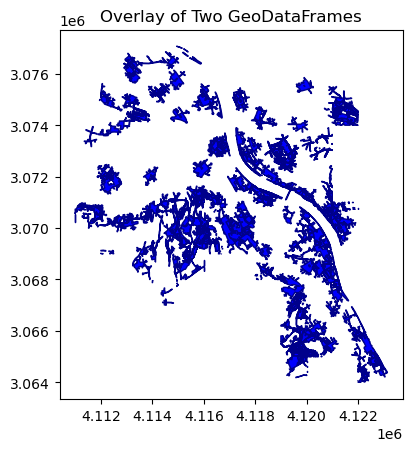

In [21]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load your GeoDataFrames


# Plot both GeoDataFrames on the same axis
fig, ax = plt.subplots()

# Plot the first GeoDataFrame
SA_GQA_urbc.plot(ax=ax, color='blue', edgecolor='darkblue')


# Add title and labels
ax.set_title('Overlay of Two GeoDataFrames')
plt.show()

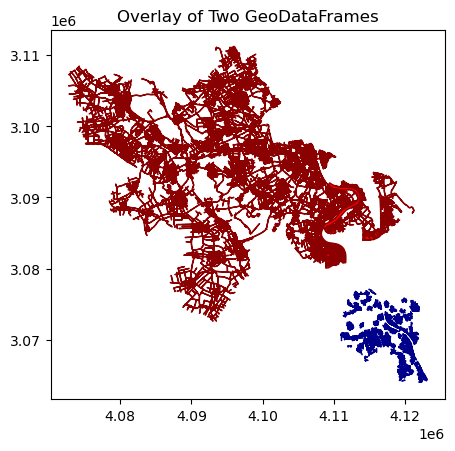

In [23]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load your GeoDataFrames


# Plot both GeoDataFrames on the same axis
fig, ax = plt.subplots()

# Plot the first GeoDataFrame
SA_GQA_urbc.plot(ax=ax, color='blue', edgecolor='darkblue')

# Plot the second GeoDataFrame
ua.plot(ax=ax, color='red', edgecolor='darkred')

# Add title and labels
ax.set_title('Overlay of Two GeoDataFrames')
plt.show()


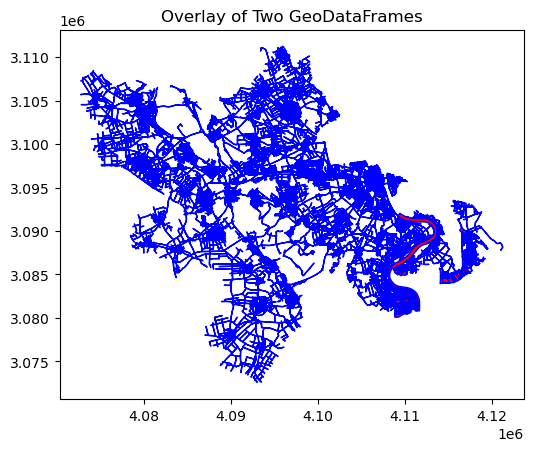

In [19]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load your GeoDataFrames


# Plot both GeoDataFrames on the same axis
fig, ax = plt.subplots()

# Plot the second GeoDataFrame
ua.plot(ax=ax, color='red', edgecolor='blue')

# Add title and labels
ax.set_title('Overlay of Two GeoDataFrames')
plt.show()

In [14]:
gpd.overlay(SA_GQA_urbc,ua,how='intersection') 


Empty GeoDataFrame
Columns: [unique_id, total_area, FID_GQA_co, FID_GQA_fi, HDENS_CLST, HDENS_NAME, HDENS_2011, POPL_2021, CNTR_CODE, MBRS_CODE_, SHAPE_AREA, SHAPE_LEN, Batch, code_2018, Pop2018, original_area_m2, geometry]
Index: []

In [13]:
ua

code_2018  Pop2018                                           geometry  \
0       12220        0  MULTIPOLYGON (((4074785.025 3098821.498, 40747...   
1       21000       13  MULTIPOLYGON (((4109841.483 3080427.359, 41098...   
2       11100      131  MULTIPOLYGON (((4114574.410 3085000.000, 41145...   
3       11100      132  MULTIPOLYGON (((4114844.029 3084869.393, 41148...   
4       11100      136  MULTIPOLYGON (((4114744.712 3085000.000, 41147...   
..        ...      ...                                                ...   
240     14100        0  MULTIPOLYGON (((4114652.278 3084698.261, 41146...   
241     21000       24  MULTIPOLYGON (((4115004.638 3084699.761, 41149...   
242     11210       51  MULTIPOLYGON (((4114928.973 3085256.555, 41149...   
243     32000        0  MULTIPOLYGON (((4115549.033 3085006.952, 41155...   
244     32000        0  MULTIPOLYGON (((4115433.546 3084625.946, 41154...   

     original_area_m2  
0         30285780.31  
1           455788.15  
2            30502.36  
3            25691.25  
4            25102.50  
..                ...  
240           7933.11  
241          81823.98  
242          14031.54  
243          17420.03  
244          12434.34  

[245 rows x 4 columns]

In [12]:
SA_GQA_urbc

unique_id     total_area  FID_GQA_co FID_GQA_fi     HDENS_CLST  \
0             0  280139.027054           3          0  GEOSTAT21_363   
1             1  344843.530783           4          0  GEOSTAT21_363   
2             2  280139.027054           3          0  GEOSTAT21_363   
3             3  344843.530783           4          0  GEOSTAT21_363   
4             4  280139.027054           3          0  GEOSTAT21_363   
...         ...            ...         ...        ...            ...   
6311       6882  396673.933859           3         95  GEOSTAT21_363   
6312       6883  396673.933859           3         95  GEOSTAT21_363   
6313       6884  396673.933859           3         95  GEOSTAT21_363   
6314       6885  257784.102800           1         95  GEOSTAT21_363   
6315       6886  110052.946898           1         99  GEOSTAT21_363   

     HDENS_NAME     HDENS_2011  POPL_2021 CNTR_CODE  MBRS_CODE_   SHAPE_AREA  \
0          Bonn  GEOSTAT11_363   522767.0        DE           1  189000000.0   
1          Bonn  GEOSTAT11_363   522767.0        DE           1  189000000.0   
2          Bonn  GEOSTAT11_363   522767.0        DE           1  189000000.0   
3          Bonn  GEOSTAT11_363   522767.0        DE           1  189000000.0   
4          Bonn  GEOSTAT11_363   522767.0        DE           1  189000000.0   
...         ...            ...        ...       ...         ...          ...   
6311       Bonn  GEOSTAT11_363   522767.0        DE           1  189000000.0   
6312       Bonn  GEOSTAT11_363   522767.0        DE           1  189000000.0   
6313       Bonn  GEOSTAT11_363   522767.0        DE           1  189000000.0   
6314       Bonn  GEOSTAT11_363   522767.0        DE           1  189000000.0   
6315       Bonn  GEOSTAT11_363   522767.0        DE           1  189000000.0   

      SHAPE_LEN  Batch                                           geometry  
0       94000.0    1.0  POLYGON ((4122260.811 3064368.727, 4122270.255...  
1       94000.0    1.0  POLYGON ((4122285.255 3064313.727, 4122255.255...  
2       94000.0    1.0  POLYGON ((4122259.346 3064403.727, 4122270.255...  
3       94000.0    1.0  POLYGON ((4122255.255 3064368.727, 4122245.255...  
4       94000.0    1.0  POLYGON ((4122268.755 3064396.227, 4122270.255...  
...         ...    ...                                                ...  
6311    94000.0    1.0  POLYGON ((4115218.589 3070818.727, 4115220.255...  
6312    94000.0    1.0  POLYGON ((4115375.255 3070973.727, 4115376.409...  
6313    94000.0    1.0  POLYGON ((4115360.255 3070993.727, 4115350.255...  
6314    94000.0    1.0  POLYGON ((4115131.424 3069966.391, 4115119.444...  
6315    94000.0    1.0  POLYGON ((4121320.255 3070953.727, 4121400.255...  

[6316 rows x 14 columns]

In [11]:
SA_GQA_ua

Empty GeoDataFrame
Columns: [unique_id, total_area, FID_GQA_co, FID_GQA_fi, HDENS_CLST, HDENS_NAME, HDENS_2011, POPL_2021, CNTR_CODE, MBRS_CODE_, SHAPE_AREA, SHAPE_LEN, Batch, code_2018, Pop2018, original_area_m2, geometry]
Index: []

In [34]:
result_erase_FIDs_left.columns

Index(['area', 'unique_id', 'geometry', 'index_right', 'FID_GQA', 'area_m2'], dtype='object')

In [35]:
SA_GQA_total2 = result_erase_FIDs_left.dissolve(by='unique_id', aggfunc={'area_m2': 'sum', 'FID_GQA': ['count', 'first']})

In [37]:
SA_GQA_total2.reset_index(inplace=True)

In [39]:
SA_GQA_total2

unique_id                                           geometry  \
0             0  POLYGON ((3274411.891 2327414.402, 3274426.911...   
1             1  POLYGON ((3274427.581 2327409.919, 3274441.581...   
2             2  POLYGON ((3274402.581 2327417.062, 3274385.706...   
3             3  POLYGON ((3274411.891 2327414.402, 3274407.581...   
4             4  POLYGON ((3274392.581 2327419.919, 3274385.706...   
...         ...                                                ...   
2425       2425  POLYGON ((3275268.037 2328007.008, 3275269.964...   
2426       2426  POLYGON ((3275300.662 2328096.198, 3275298.494...   
2427       2427  POLYGON ((3275307.581 2327914.919, 3275303.831...   
2428       2428  POLYGON ((3275091.685 2327963.127, 3275090.800...   
2429       2429  POLYGON ((3274875.190 2328022.091, 3274877.446...   

      (area_m2, sum)  (FID_GQA, count) (FID_GQA, first)  
0      222846.338025                 2                0  
1      222846.338025                 2                0  
2      222846.338025                 2                0  
3      222846.338025                 2                0  
4      222846.338025                 2                0  
...              ...               ...              ...  
2425   492347.168897                 2                8  
2426   492347.168897                 2                8  
2427   277289.232868                 1                8  
2428   277289.232868                 1                8  
2429   277289.232868                 1                8  

[2430 rows x 5 columns]

In [32]:
SA_GQA_urbc.columns

Index(['unique_id', 'total_area', 'FID_GQA_co', 'FID_GQA_fi', 'HDENS_CLST',
       'HDENS_NAME', 'HDENS_2011', 'POPL_2021', 'CNTR_CODE', 'MBRS_CODE_',
       'SHAPE_AREA', 'SHAPE_LEN', 'Batch', 'geometry'],
      dtype='object')

In [31]:
SA_GQA_ua.columns

Index(['unique_id', 'total_area', 'FID_GQA_co', 'FID_GQA_fi', 'HDENS_CLST',
       'HDENS_NAME', 'HDENS_2011', 'POPL_2021', 'CNTR_CODE', 'MBRS_CODE_',
       'SHAPE_AREA', 'SHAPE_LEN', 'Batch', 'code_2018', 'Pop2018',
       'original_area_m2', 'geometry'],
      dtype='object')

In [33]:
SA_final.columns

Index(['FID_GQA', 'geometry', 'area_m2'], dtype='object')

In [30]:
SA_GQA_total.columns

Index(['unique_id', 'geometry', 'total_area_m2', 'FID_GQA_count',
       'FID_GQA_first'],
      dtype='object')

In [19]:
outtbl = pd.read_csv(csv_path)
cities_ls = outtbl.uc_code.to_list()

In [21]:
if 'GEOSTAT21_006' in cities_ls:
    print('in')
else:
    print('out')

out


In [8]:
codes.head()

FREQUENCY     HDENS_CLST            HDENS_NAME     HDENS_2011  \
0          1  GEOSTAT21_002       Oulu / Uleåborg  GEOSTAT11_002   
1          1  GEOSTAT21_003                  Umeå  GEOSTAT11_003   
2          1  GEOSTAT21_004             Trondheim  GEOSTAT11_004   
3          1  GEOSTAT21_005             Jyväskylä  GEOSTAT11_005   
4          1  GEOSTAT21_006  Tampere / Tammerfors  GEOSTAT11_006   

  agglomerationId_identifier agglomerationName_nameEng  \
0                 AG_FI_00_6                      Oulu   
1                SE_a_ag2480                      Umea   
2                 AG_NO_00_3                 Trondheim   
3                 AG_FI_00_9                 Jyvaskyla   
4                 AG_FI_00_3                   Tampere   

                          UA2018  
0       FI004L4_OULU_UA2018_v013  
1       SE005L1_UMEA_UA2018_v013  
2  NO003L1_TRONDHEIM_UA2018_v013  
3  FI009L2_JYVASKYLA_UA2018_v013  
4    FI002L3_TAMPERE_UA2018_v013

In [10]:
codes.query('HDENS_NAME=="Bilbao"')

FREQUENCY     HDENS_CLST HDENS_NAME     HDENS_2011  \
324          1  GEOSTAT21_650     Bilbao  GEOSTAT11_650   
325          1  GEOSTAT21_650     Bilbao  GEOSTAT11_650   

    agglomerationId_identifier agglomerationName_nameEng  \
324             AG_ES_21_48013                 Barakaldo   
325             AG_ES_21_48020                    Bilbao   

                               UA2018  
324  ES019L3_BILBAO_UA2018_v013\r\r\n  
325  ES019L3_BILBAO_UA2018_v013\r\r\n

In [14]:
codes.query('HDENS_NAME=="Bilbao"').UA2018.values[0].strip()

'ES019L3_BILBAO_UA2018_v013'

In [52]:
ua_path[:-5]

'IE001L1_DUBLIN_UA2018'

In [53]:
SA_GQA_urbc

unique_id  total_area_m2  FID_GQA_count FID_GQA_first     HDENS_CLST  \
0             0   1.095625e+05              2            0   GEOSTAT21_905   
1             1   1.095625e+05              2            0   GEOSTAT21_905   
2             2   1.095625e+05              2            0   GEOSTAT21_905   
3             3   1.095625e+05              2            0   GEOSTAT21_905   
4             4   1.095625e+05              2            0   GEOSTAT21_905   
...         ...            ...            ...           ...            ...   
6207       6309   7.388210e+05              3           77   GEOSTAT21_905   
6208       6310   7.388210e+05              3           77   GEOSTAT21_905   
6209       6311   7.388210e+05              3           77   GEOSTAT21_905   
6210       6312   7.388210e+05              3           77   GEOSTAT21_905   
6211       6313   1.286925e+06              5           87   GEOSTAT21_905   

     HDENS_NAME HDENS_2011  POPL_2021 CNTR_CODE  MBRS_CODE_  SHAPE_AREA  \
0       Utrecht       None   346992.0        NL           1  58000000.0   
1       Utrecht       None   346992.0        NL           1  58000000.0   
2       Utrecht       None   346992.0        NL           1  58000000.0   
3       Utrecht       None   346992.0        NL           1  58000000.0   
4       Utrecht       None   346992.0        NL           1  58000000.0   
...         ...        ...        ...       ...         ...         ...   
6207    Utrecht       None   346992.0        NL           1  58000000.0   
6208    Utrecht       None   346992.0        NL           1  58000000.0   
6209    Utrecht       None   346992.0        NL           1  58000000.0   
6210    Utrecht       None   346992.0        NL           1  58000000.0   
6211    Utrecht       None   346992.0        NL           1  58000000.0   

      SHAPE_LEN  Batch                                           geometry  
0       42000.0    1.0  POLYGON ((3987462.287 3227333.752, 3987457.287...  
1       42000.0    1.0  POLYGON ((3987393.169 3227338.262, 3987387.287...  
2       42000.0    1.0  POLYGON ((3987457.287 3227334.085, 3987457.287...  
3       42000.0    1.0  POLYGON ((3987393.169 3227338.262, 3987385.014...  
4       42000.0    1.0  POLYGON ((3987380.923 3227306.934, 3987382.287...  
...         ...    ...                                                ...  
6207    42000.0    1.0  POLYGON ((3979862.287 3232288.752, 3979852.287...  
6208    42000.0    1.0  POLYGON ((3979631.176 3232084.307, 3979632.287...  
6209    42000.0    1.0  POLYGON ((3979607.287 3232088.752, 3979612.287...  
6210    42000.0    1.0  POLYGON ((3979622.287 3232058.752, 3979627.287...  
6211    42000.0    1.0  POLYGON ((3987277.287 3232333.752, 3987276.784...  

[6212 rows x 14 columns]

In [ ]:
# Check if the file exists to determine if headers need to be written
file_exists = os.path.isfile(log_path)

# Open the log file in append mode
with open(log_path, 'a', newline='') as csvfile:
    log_writer = csv.writer(csvfile)

    # Write the header if the file is new
    if not file_exists:
        log_writer.writerow(['Timestamp', 'HDENS_NAME', 'agglo_Id', 'uc_km2', 'gdf2_km2', 'gdf1_gdf2_km2', 
                                'ua_km2', 'uagreen_km2', 'uagreen_urbc_km2', 'nqgreen_m2', 'green_not_covered_by_gdf1_m2',
                                'GQA_m2', 'GNA_m2', 'prDuration'])

    # Write the log entry
    log_writer.writerow(log_entry)
write_log(csv_path, log_entry)

In [40]:
del TotalPop
if TotalPop is None:
    print ('hello')

NameError: name 'TotalPop' is not defined

In [38]:
SA_GQA_ua.head()
#KeyError: "['original_area_m2'] not in index"
##SA_GQA_ua = SA_GQA_ua[['unique_id', 'total_area_m2','code_2018',  'Pop2018','original_area_m2',  'geometry']]

unique_id  total_area_m2  FID_GQA_count FID_GQA_first     HDENS_CLST  \
0          0  109562.465962              2            0   GEOSTAT21_905   
1          1  109562.465962              2            0   GEOSTAT21_905   
2          2  109562.465962              2            0   GEOSTAT21_905   
3          3  109562.465962              2            0   GEOSTAT21_905   
4         22  109562.465962              2            0   GEOSTAT21_905   

  HDENS_NAME HDENS_2011  POPL_2021 CNTR_CODE  MBRS_CODE_  SHAPE_AREA  \
0    Utrecht       None   346992.0        NL           1  58000000.0   
1    Utrecht       None   346992.0        NL           1  58000000.0   
2    Utrecht       None   346992.0        NL           1  58000000.0   
3    Utrecht       None   346992.0        NL           1  58000000.0   
4    Utrecht       None   346992.0        NL           1  58000000.0   

   SHAPE_LEN  Batch code_2018  Pop2018  \
0    42000.0    1.0     14100        0   
1    42000.0    1.0     14100        0   
2    42000.0    1.0     14100        0   
3    42000.0    1.0     14100        0   
4    42000.0    1.0     14100        0   

                                            geometry  
0  POLYGON ((3987457.287 3227334.085, 3987457.287...  
1  POLYGON ((3987387.287 3227338.752, 3987385.014...  
2  POLYGON ((3987457.287 3227333.752, 3987447.287...  
3  POLYGON ((3987385.014 3227327.388, 3987387.287...  
4  POLYGON ((3987637.287 3227363.752, 3987637.287...

In [21]:
codes.head()

FREQUENCY     HDENS_CLST            HDENS_NAME     HDENS_2011  \
0          1  GEOSTAT21_002       Oulu / Uleåborg  GEOSTAT11_002   
1          1  GEOSTAT21_003                  Umeå  GEOSTAT11_003   
2          1  GEOSTAT21_004             Trondheim  GEOSTAT11_004   
3          1  GEOSTAT21_005             Jyväskylä  GEOSTAT11_005   
4          1  GEOSTAT21_006  Tampere / Tammerfors  GEOSTAT11_006   

  agglomerationId_identifier agglomerationName_nameEng  \
0                 AG_FI_00_6                      Oulu   
1                SE_a_ag2480                      Umea   
2                 AG_NO_00_3                 Trondheim   
3                 AG_FI_00_9                 Jyvaskyla   
4                 AG_FI_00_3                   Tampere   

                          UA2018  
0       FI004L4_OULU_UA2018_v013  
1       SE005L1_UMEA_UA2018_v013  
2  NO003L1_TRONDHEIM_UA2018_v013  
3  FI009L2_JYVASKYLA_UA2018_v013  
4    FI002L3_TAMPERE_UA2018_v013

In [ ]:
# select a subset of columns
SA_final = SA_final[['FID_GQA',
 'area_m2',
 'area_ha',
 'geometry']]

In [57]:
SA_final

FID_GQA                                           geometry  FacilityID  \
0        0   MULTIPOLYGON (((4651382.019 3931912.035, 46513...           2   
1        1   POLYGON ((4653962.019 3932312.035, 4653992.019...           4   
2       10   POLYGON ((4652766.093 3932514.072, 4652762.019...         102   
3      100   MULTIPOLYGON (((4650402.019 3934512.035, 46504...        1076   
4      101   MULTIPOLYGON (((4651642.019 3934842.035, 46516...        1092   
..      ...                                                ...         ...   
170     95   MULTIPOLYGON (((4650261.539 3934545.112, 46502...        1015   
171     96   MULTIPOLYGON (((4652817.696 3934168.944, 46528...        1025   
172     97   POLYGON ((4651516.230 3934668.351, 4651473.894...        1038   
173     98   MULTIPOLYGON (((4652892.019 3934462.035, 46528...        1052   
174     99   MULTIPOLYGON (((4649262.019 3934813.464, 46492...        1069   

              Name  FromBreak  ToBreak   Shape_Leng  Shape_Area  
0      0 : 0 - 400        0.0    400.0  1941.127601     28987.5  
1      1 : 0 - 400        0.0    400.0  3535.222551    124375.0  
2     10 : 0 - 400        0.0    400.0  4048.773240    163637.5  
3    100 : 0 - 400        0.0    400.0  5042.758993    137612.5  
4    101 : 0 - 400        0.0    400.0  6021.435962    174962.5  
..             ...        ...      ...          ...         ...  
170   95 : 0 - 400        0.0    400.0  4754.873273     79812.5  
171   96 : 0 - 400        0.0    400.0  4341.821693    145837.5  
172   97 : 0 - 400        0.0    400.0  3809.244825     93275.0  
173   98 : 0 - 400        0.0    400.0  4008.695050     97875.0  
174   99 : 0 - 400        0.0    400.0  5438.843141    144612.5  

[175 rows x 8 columns]

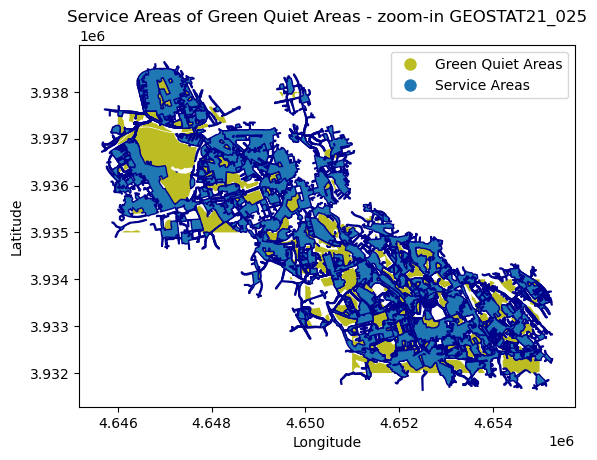

In [60]:
# Plot GQA
colors_ls = ['tab:olive', 'tab:blue']
ax = GQA.plot(facecolor=colors_ls[0], edgecolor='None', legend=True)

# Plot SAs
SA_final.plot(ax=ax, facecolor=colors_ls[1], edgecolor='darkblue', legend=True)

# Set the limits to zoom in on a specified region
#ax.set_ylim(2467000, 2468500)
#ax.set_xlim(3485000, 3487000)

# Set plot labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'Service Areas of Green Quiet Areas - zoom-in {uc_code}')

# Show the legend with customized labels
legend_labels = {'Green Quiet Areas': 'Green Quiet Areas', 'Service Areas': 'Service Areas'}
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors_ls]
ax.legend(handles=handles, labels=legend_labels.values())

# Display the plot
plt.show()

In [6]:
 # Read all layers from the geodatabase
group_id = str(230)
ID_GROUP = "GROUP_" + group_id
SA = gpd.read_file(gdb_path, driver='FileGDB', layer=f"{ID_GROUP}_sa")

path = os.path.join(outPath, 'GUA_pt_ALL_GQA_FID.shp')  
pts_GQA_FID = gpd.read_file(path)

# select a subset of columns
pts_GQA_FID = pts_GQA_FID[['FID_GQA', 'country', 'fua_name','fua_code',
'HDENS_2011', 'code_2018', 'class_2018', 'noisy',
'area_m2', 'area_ha', 'area_km2']]

# Add green area information to the SA feature
SA_FID = SA.merge(pts_GQA_FID, left_index= True, right_index= True, how= 'left')

# Dissolve by GQA identifier
SA_FID_dis = SA_FID.dissolve('FID_GQA')
SA_FID_dis.reset_index(inplace=True)

# Save temporary file
file_path = os.path.join(outdata_f, 'SA_FID_dis.shp')
SA_FID_dis.to_file(file_path, driver='ESRI Shapefile')

Q:\UserTemp\ubach\AppData\Local\Temp\11\ipykernel_64008\2941010059.py:23: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  SA_FID_dis.to_file(file_path, driver='ESRI Shapefile')


#### Step 3: Erase those areas of SA overlaping the GreenUrban Areas

In [35]:
# Load QGA
path = os.path.join(outPath, 'GQA.shp')  
GQA = gpd.read_file(path)

# Remove QGA delineation from the SA
SA_final = gpd.overlay(SA_FID_dis, GQA, how='difference')

# Save temporary file
file_path = os.path.join(outdata_f, 'SA_final.shp')
SA_final.to_file(file_path, driver='ESRI Shapefile')

Q:\UserTemp\ubach\AppData\Local\Temp\11\ipykernel_64008\929151681.py:10: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  SA_final.to_file(file_path, driver='ESRI Shapefile')


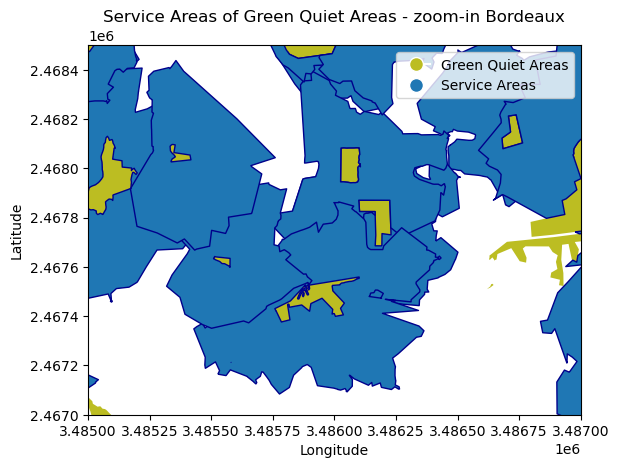

In [36]:
# Plot GQA
colors_ls = ['tab:olive', 'tab:blue']
ax = GQA.plot(facecolor=colors_ls[0], edgecolor='None', legend=True)

# Plot SAs
SA_final.plot(ax=ax, facecolor=colors_ls[1], edgecolor='darkblue', legend=True)

# Set the limits to zoom in on a specified region
ax.set_ylim(2467000, 2468500)
ax.set_xlim(3485000, 3487000)

# Set plot labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Service Areas of Green Quiet Areas - zoom-in Bordeaux')

# Show the legend with customized labels
legend_labels = {'Green Quiet Areas': 'Green Quiet Areas', 'Service Areas': 'Service Areas'}
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors_ls]
ax.legend(handles=handles, labels=legend_labels.values())

# Display the plot
plt.show()

#### Step 4: Calculate the portion of SA that intersect between each other (SA_final)

Some polygons from the service areas are intersecting with other service areas generated from different GQAs. This meaning some polygons overlap where different service areas coincide. To properly assign the amount of qreen quiet area with accessibility, we need to differentiate these areas and sum the number of areas from the different GQA that serves.

In [37]:
# select a subset of columns
SA_final = SA_final[['FID_GQA',
 'area_m2',
 'area_ha',
 'geometry']]

In [38]:
## Creating non-overlapping units following the proposed approach from:
## https://gis.stackexchange.com/questions/187402/how-to-find-the-intersection-areas-of-overlapping-buffer-zones-in-single-shapefi/187499#187499

# Split multipart polygons to single part polygons
SA_FID_mp = SA_final.explode(ignore_index=True)

# create unique features from input polygons
rings = [LineString(list(shape(geometry).exterior.coords)) for geometry in SA_FID_mp['geometry']]
union = unary_union(rings)
SA_no_overlaps = [geom for geom in polygonize(union)]

# Create a new GeoDataFrame for the result
SA_no_overlaps_gdf = gpd.GeoDataFrame(geometry=SA_no_overlaps)

# Add an 'area' column to the new GeoDataFrame
SA_no_overlaps_gdf['area'] = SA_no_overlaps_gdf['geometry'].area
SA_no_overlaps_gdf.crs = SA_FID_mp.crs

# remove again the GQA
SA_no_overlaps_gdf = gpd.overlay(SA_no_overlaps_gdf, GQA, how='difference')

# Add unique id field
SA_no_overlaps_gdf['unique_id'] = range(len(SA_no_overlaps_gdf))

# Save the result GeoDataFrame to shapefile
file_path = os.path.join(outdata_f, 'SA_no_overlaps.shp')
SA_no_overlaps_gdf.to_file(file_path, driver='ESRI Shapefile')

Q:\UserTemp\ubach\AppData\Local\Temp\11\ipykernel_64008\208558994.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  SA_no_overlaps_gdf = gpd.overlay(SA_no_overlaps_gdf, GQA, how='difference')


In [39]:
result_erase_FIDs_left = gpd.sjoin(SA_no_overlaps_gdf, SA_final, how= 'left', op='intersects')
SA_GQA_total = result_erase_FIDs_left.dissolve(by='unique_id', aggfunc={'area_m2': 'sum', 'FID_GQA': ['count', 'first']})
SA_GQA_total.reset_index(inplace=True)
SA_GQA_total.columns = ['unique_id', 'geometry', 'total_area_m2', 'FID_GQA_count', 'FID_GQA_first']

c:\Users\ubach\.conda\envs\geospatial_ETC_DI_v4\lib\site-packages\IPython\core\interactiveshell.py:3382: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [40]:
SA_GQA_total

unique_id                                           geometry  \
0             0  POLYGON ((3485217.304 2475183.692, 3485252.234...   
1             1  POLYGON ((3485365.031 2474998.691, 3485383.825...   
2             2  POLYGON ((3485302.448 2474814.608, 3485311.259...   
3             3  POLYGON ((3484916.041 2474668.708, 3484904.215...   
4             4  POLYGON ((3484966.869 2474849.688, 3484952.669...   
...         ...                                                ...   
3333       3333  POLYGON ((3486715.194 2474454.977, 3486676.845...   
3334       3334  POLYGON ((3486929.266 2474098.952, 3486931.607...   
3335       3335  POLYGON ((3482007.665 2471991.615, 3482010.723...   
3336       3336  POLYGON ((3486679.045 2473691.123, 3486679.114...   
3337       3337  POLYGON ((3486679.052 2473690.057, 3486686.478...   

      total_area_m2  FID_GQA_count  FID_GQA_first  
0     178770.002306              4            327  
1      16265.322519              2            341  
2     120007.896623              5            337  
3       8126.677858              2            327  
4     167987.200262              3            327  
...             ...            ...            ...  
3333  106263.749138              5            435  
3334   45479.516207              5             22  
3335    1696.530171              1            434  
3336   35007.298213              3             22  
3337   35007.298213              3             22  

[3338 rows x 5 columns]

In [41]:
# Remove the outer areas from urban centers
# Load urban center delineation
path = os.path.join(indata_f, 'HDC2021_RG.shp')  
urban_center = gpd.read_file(path)
urban_center = urban_center.query('HDENS_NAME =="Bordeaux"')

# Remove QGA delineation from the SA
SA_GQA_urbc = gpd.overlay(SA_GQA_total, urban_center, how='intersection')
file_path = os.path.join(outdata_f, 'SA_GQA_urbc.shp')
SA_GQA_urbc.to_file(file_path, driver='ESRI Shapefile')

Q:\UserTemp\ubach\AppData\Local\Temp\11\ipykernel_64008\3705143651.py:7: UserWarning: `keep_geom_type=True` in overlay resulted in 83 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  SA_GQA_urbc = gpd.overlay(SA_GQA_total, urban_center, how='intersection')
Q:\UserTemp\ubach\AppData\Local\Temp\11\ipykernel_64008\3705143651.py:9: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  SA_GQA_urbc.to_file(file_path, driver='ESRI Shapefile')


#### Step 5: Final computations including population

Compute Total Green Areas

In [146]:
# Read Urban Atlas data
data_f = r'A:\Copernicus\UrbanAtlas\UrbanAtlas\UA2018'
file_path = os.path.join(data_f, r'FR007L2_BORDEAUX_UA2018_v013\Data\FR007L2_BORDEAUX_UA2018_v013.gpkg')

# Read the GeoPackage file
ua = gpd.read_file(file_path, layer='FR007L2_BORDEAUX_UA2018')

In [152]:
# Read shapefile
data_f = r'S:\Common workspace\ETC_DI\AP23_GreenQuietAreas\UrbanQuiet\Input'
file_path = os.path.join(data_f, 'HDC2021_RG.shp')

# Read the GeoPackage file
uc = gpd.read_file(file_path)

# Urban center for Bordeaux
uc_bdx = uc.query('HDENS_NAME == "Bordeaux"')

In [154]:
# urban green in all FUA
uagreen = ua.query('code_2018 == "14100" or code_2018 == "31000"')
# urban green within the Urban Center
uagreen_urbc = gpd.overlay(uagreen, uc_bdx, how='intersection')

In [148]:
ua.area.sum()*0.0001

555595.7914096091

In [145]:
uagreen.area.sum()*0.0001

275402.4806754545

In [155]:
uagreen_urbc.area.sum()*0.0001

1938.046991322812

In [150]:
GQA.area.sum()*0.0001

1105.4458778726878

In [66]:
uagreen_urbc.head()

country  fua_name fua_code code_2018         class_2018 prod_date  \
0      FR  Bordeaux  FR007L2     14100  Green urban areas   2020-01   
1      FR  Bordeaux  FR007L2     14100  Green urban areas   2020-01   
2      FR  Bordeaux  FR007L2     14100  Green urban areas   2020-01   
3      FR  Bordeaux  FR007L2     14100  Green urban areas   2020-01   
4      FR  Bordeaux  FR007L2     14100  Green urban areas   2020-01   

      identifier    perimeter           area comment  ...  FID_GQA_first  \
0  41439-FR007L2   324.792007    5752.133073    None  ...            327   
1  41439-FR007L2   324.792007    5752.133073    None  ...            327   
2  41548-FR007L2  2869.748431  247101.268040    None  ...            327   
3  41090-FR007L2   167.670852    1843.689929    None  ...             81   
4  41102-FR007L2   482.098104    5404.861439    None  ...             81   

      HDENS_CLST  HDENS_NAME     HDENS_2011  POPL_2021 CNTR_CODE MBRS_CODE_  \
0  GEOSTAT21_595    Bordeaux  GEOSTAT11_595   690408.0        FR          1   
1  GEOSTAT21_595    Bordeaux  GEOSTAT11_595   690408.0        FR          1   
2  GEOSTAT21_595    Bordeaux  GEOSTAT11_595   690408.0        FR          1   
3  GEOSTAT21_595    Bordeaux  GEOSTAT11_595   690408.0        FR          1   
4  GEOSTAT21_595    Bordeaux  GEOSTAT11_595   690408.0        FR          1   

    SHAPE_AREA  SHAPE_LEN                                           geometry  
0  183000000.0    88000.0  POLYGON ((3484981.105 2474871.035, 3484980.735...  
1  183000000.0    88000.0  POLYGON ((3484977.002 2474874.618, 3484981.950...  
2  183000000.0    88000.0  POLYGON ((3484814.812 2475172.268, 3484814.790...  
3  183000000.0    88000.0  POLYGON ((3484821.752 2468129.080, 3484821.678...  
4  183000000.0    88000.0  POLYGON ((3484808.507 2468197.513, 3484815.016...  

[5 rows x 24 columns]

In [157]:
# All green areas (GUAs and forests) in the urban center (including data outside the ncm)
TotalGreenArea = uagreen_urbc.geometry.area.sum()
TotalGreenAreaHa = TotalGreenArea/10000

Green areas excluded (areas not covered by ncm)

In [160]:
# Load the delineation for the agglomeration
# Read noise data
file_path = os.path.join(indata_f, 'NoiseData\Agglomerations-StrategicNoiseMaps-multipoly.gpkg')
# Read the GeoPackage file
ncm = gpd.read_file(file_path, layer='NoiseContours_roadsInAgglomeration_Lden')

# Read agglomerations delineations
file_path = os.path.join(indata_f, 'NoiseData\DF15_latestDelivery_POLARBEAR_230724.gpkg')
agls = gpd.read_file(file_path, layer = 'dbo.DF15_AgglomerationSource_Valid_LatestDelivery')

# select Bordeaux
agl_BDX = agls.query('agglomerationName_localName == "Bordeaux"')

# Select green areas within the noise contour maps covered by noise data
uagreen_urbc_BDX = gpd.overlay(uagreen_urbc, agl_BDX, how='intersection')

In [161]:
# Excluded areas = TotalGreen in the urban center - TotalGreen in the uc & ncm 
TotalGreen_urbc_ncm = uagreen_urbc_BDX.area.sum()
green_excluded = TotalGreenArea - TotalGreen_urbc_ncm

In [188]:
TotalGreenArea/10000

1938.0469913228117

In [186]:
TotalGreen_urbc_ncm

19291870.893650003

Percentage of Green Quiet Areas

In [162]:
## Compute as:
## % of green quiet areas =  TotalGQA/(TotalGreenAreas-Green excluded) * 100
TotalGQA_m2 = GQA.area_m2.sum()

In [163]:
5.878832e+06+5.175627e+06

11054459.0

In [164]:
TotalGQA_m2

11054458.778726878

In [165]:
GQA.columns

Index(['country', 'fua_name', 'fua_code', 'HDENS_2011', 'code_2018',
       'class_2018', 'noisy', 'area_m2', 'area_ha', 'area_km2', 'geometry'],
      dtype='object')

In [166]:
TotalGreenArea

19380469.913228117

In [167]:
ua_urbc = gpd.overlay(ua, urban_center, how='intersection')

In [168]:
TotalPop = ua_urbc.Pop2018.sum()

In [169]:
ua= ua[['area','code_2018', 'Pop2018', 'geometry']].query('Pop2018>0')

In [170]:
ua['original_area_m2'] = round(ua.geometry.area,2)

In [171]:
ua

area code_2018  Pop2018  \
0        6924.354692     11210       49   
1        5142.000564     11100        2   
2        3982.575676     11220       14   
3        4617.098115     11220       11   
4        3389.507534     11220        6   
...              ...       ...      ...   
69416   22462.809102     23000        9   
69417   12689.972692     23000       10   
69419   20909.008640     23000        1   
69421   37183.835180     23000        3   
69450  170388.838000     12100       27   

                                                geometry  original_area_m2  
0      MULTIPOLYGON (((3488006.429 2468985.638, 34880...           6924.35  
1      MULTIPOLYGON (((3446442.890 2470711.718, 34464...           5142.00  
2      MULTIPOLYGON (((3503605.413 2445087.190, 35036...           3982.58  
3      MULTIPOLYGON (((3467543.865 2449883.544, 34675...           4617.10  
4      MULTIPOLYGON (((3488582.743 2463459.866, 34885...           3389.51  
...                                                  ...               ...  
69416  MULTIPOLYGON (((3497140.160 2494000.000, 34971...          22462.81  
69417  MULTIPOLYGON (((3500533.866 2489220.226, 35005...          12689.97  
69419  MULTIPOLYGON (((3482000.000 2497056.498, 34819...          20909.01  
69421  MULTIPOLYGON (((3501000.000 2471810.518, 35010...          37183.84  
69450  MULTIPOLYGON (((3471511.699 2457137.839, 34715...         170388.84  

[38973 rows x 5 columns]

In [172]:
# Remove QGA delineation from the SA
SA_GQA_ua = gpd.overlay(SA_GQA_urbc,ua, how='intersection')
#file_path = os.path.join(outdata_f, 'SA_GQA_urbc.shp')
#SA_GQA_urbc.to_file(file_path, driver='ESRI Shapefile')

Q:\UserTemp\ubach\AppData\Local\Temp\11\ipykernel_64008\936395552.py:2: UserWarning: `keep_geom_type=True` in overlay resulted in 45 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  SA_GQA_ua = gpd.overlay(SA_GQA_urbc,ua, how='intersection')


In [173]:
SA_GQA_ua

unique_id  total_area_m2  FID_GQA_count  FID_GQA_first     HDENS_CLST  \
0              0  178770.002306              4            327  GEOSTAT21_595   
1              2  120007.896623              5            337  GEOSTAT21_595   
2              0  178770.002306              4            327  GEOSTAT21_595   
3              0  178770.002306              4            327  GEOSTAT21_595   
4              1   16265.322519              2            341  GEOSTAT21_595   
...          ...            ...            ...            ...            ...   
12104       3335    1696.530171              1            434  GEOSTAT21_595   
12105       3335    1696.530171              1            434  GEOSTAT21_595   
12106       3335    1696.530171              1            434  GEOSTAT21_595   
12107       3335    1696.530171              1            434  GEOSTAT21_595   
12108       3335    1696.530171              1            434  GEOSTAT21_595   

      HDENS_NAME     HDENS_2011  POPL_2021 CNTR_CODE  MBRS_CODE_   SHAPE_AREA  \
0       Bordeaux  GEOSTAT11_595   690408.0        FR           1  183000000.0   
1       Bordeaux  GEOSTAT11_595   690408.0        FR           1  183000000.0   
2       Bordeaux  GEOSTAT11_595   690408.0        FR           1  183000000.0   
3       Bordeaux  GEOSTAT11_595   690408.0        FR           1  183000000.0   
4       Bordeaux  GEOSTAT11_595   690408.0        FR           1  183000000.0   
...          ...            ...        ...       ...         ...          ...   
12104   Bordeaux  GEOSTAT11_595   690408.0        FR           1  183000000.0   
12105   Bordeaux  GEOSTAT11_595   690408.0        FR           1  183000000.0   
12106   Bordeaux  GEOSTAT11_595   690408.0        FR           1  183000000.0   
12107   Bordeaux  GEOSTAT11_595   690408.0        FR           1  183000000.0   
12108   Bordeaux  GEOSTAT11_595   690408.0        FR           1  183000000.0   

       SHAPE_LEN          area code_2018  Pop2018  original_area_m2  \
0        88000.0  13731.057897     11100      205          13731.06   
1        88000.0  13731.057897     11100      205          13731.06   
2        88000.0   5847.677548     11100       97           5847.68   
3        88000.0  17427.450350     11100      334          17427.45   
4        88000.0  17427.450350     11100      334          17427.45   
...          ...           ...       ...      ...               ...   
12104    88000.0   1512.786242     11100       14           1512.79   
12105    88000.0   4612.121016     11100       21           4612.12   
12106    88000.0  24852.337739     11210      105          24852.34   
12107    88000.0  26662.307205     11210      124          26662.31   
12108    88000.0  29886.493237     11210      172          29886.49   

                                                geometry  
0      POLYGON ((3485289.956 2475183.401, 3485289.466...  
1      POLYGON ((3485454.274 2475026.025, 3485461.633...  
2      POLYGON ((3485084.487 2474907.005, 3485084.447...  
3      POLYGON ((3485217.957 2474815.535, 3485169.129...  
4      POLYGON ((3485216.513 2474824.305, 3485222.556...  
...                                                  ...  
12104  POLYGON ((3482188.559 2471981.834, 3482170.351...  
12105  POLYGON ((3482336.518 2471996.949, 3482336.514...  
12106  MULTIPOLYGON (((3482153.713 2471812.425, 34821...  
12107  POLYGON ((3482272.516 2471680.360, 3482190.058...  
12108  POLYGON ((3482269.798 2471655.461, 3482275.268...  

[12109 rows x 17 columns]

In [175]:
SA_GQA_ua = SA_GQA_ua[['unique_id', 'total_area_m2','code_2018',  'Pop2018','original_area_m2',  'geometry']]

In [ ]:
SA_GQA_ua['final_area_m2'] = round(SA_GQA_ua.geometry.area,2)
SA_GQA_ua['area_prop'] = SA_GQA_ua['final_area_m2']/SA_GQA_ua['original_area_m2']
SA_GQA_ua['Pop2018_poly'] = SA_GQA_ua['Pop2018']*SA_GQA_ua['area_prop']
SA_GQA_ua['Pop2018_final'] = round(SA_GQA_ua.Pop2018_poly,0)

In [177]:
SA_GQA_ua.head()

unique_id  total_area_m2 code_2018  Pop2018  original_area_m2  \
0          0  178770.002306     11100      205          13731.06   
1          2  120007.896623     11100      205          13731.06   
2          0  178770.002306     11100       97           5847.68   
3          0  178770.002306     11100      334          17427.45   
4          1   16265.322519     11100      334          17427.45   

                                            geometry  final_area_m2  \
0  POLYGON ((3485289.956 2475183.401, 3485289.466...        1079.71   
1  POLYGON ((3485454.274 2475026.025, 3485461.633...        1459.88   
2  POLYGON ((3485084.487 2474907.005, 3485084.447...        5847.68   
3  POLYGON ((3485217.957 2474815.535, 3485169.129...       17403.49   
4  POLYGON ((3485216.513 2474824.305, 3485222.556...          23.96   

   area_prop  Pop2018_poly  Pop2018_final  
0   0.078633     16.119699           16.0  
1   0.106320     21.795506           22.0  
2   1.000000     97.000000           97.0  
3   0.998625    333.540803          334.0  
4   0.001375      0.459197            0.0

In [178]:
# compute the weighted median for the area
column_to_compute_median = 'total_area_m2'

# Compute the weighted median
weighted_median = np.average(SA_GQA_ua[column_to_compute_median], weights=SA_GQA_ua['Pop2018_poly'])

In [179]:
GQA.head()

country  fua_name fua_code     HDENS_2011 code_2018         class_2018  \
0      FR  Bordeaux  FR007L2  GEOSTAT11_595     14100  Green urban areas   
1      FR  Bordeaux  FR007L2  GEOSTAT11_595     14100  Green urban areas   
2      FR  Bordeaux  FR007L2  GEOSTAT11_595     14100  Green urban areas   
3      FR  Bordeaux  FR007L2  GEOSTAT11_595     14100  Green urban areas   
4      FR  Bordeaux  FR007L2  GEOSTAT11_595     14100  Green urban areas   

   noisy      area_m2  area_ha  area_km2  \
0      0  5482.520475     0.55      0.01   
1      0  9437.546036     0.94      0.01   
2      0  3340.957782     0.33      0.00   
3      0  5018.856511     0.50      0.00   
4      0  2946.033960     0.29      0.00   

                                            geometry  
0  POLYGON ((3484952.812 2474926.929, 3484978.426...  
1  POLYGON ((3485253.561 2476326.538, 3485293.775...  
2  POLYGON ((3482568.094 2469317.124, 3482588.419...  
3  POLYGON ((3485988.105 2474998.814, 3485934.404...  
4  POLYGON ((3486150.554 2475185.315, 3486152.530...

Compute Percentage of Green Quiet Areas

In [180]:
## Compute as:
## % of green quiet areas =  TotalGQA/(TotalGreenAreas-Green excluded) * 100
TotalGQA_m2 = GQA.area_m2.sum()


Capturing variables to build final tables 

In [190]:
# Create lists to capture output variables
HDENS_NAME_ls = []
HDENS_2011_ls = []
CNTR_CODE_ls = []
POPL_2021_ls = []

In [192]:
UrbanCenterName = urban_center.HDENS_NAME.unique()[0]
UrbanCenterCode = urban_center.HDENS_2011.unique()[0]
UrbanCenterCountry = urban_center.CNTR_CODE.unique()[0]
UrbanCenterPOP21 = urban_center.POPL_2021.unique()[0]

In [193]:
HDENS_NAME_ls.append(UrbanCenterName)
HDENS_2011_ls.append(UrbanCenterCode)
CNTR_CODE_ls.append(UrbanCenterCountry)
POPL_2021_ls.append(UrbanCenterPOP21)

In [200]:
# import noiseqg from the previous notebook
%store -r nqgreen_area
nqgreen_area

code_2018  noisy       area_m2  area_ha  area_km2
0     14100      0  5.878832e+06   587.88      5.88
1     14100      1  5.398097e+06   539.81      5.40
2     31000      0  5.175627e+06   517.56      5.18
3     31000      1  2.839315e+06   283.93      2.84

In [208]:
TotalGreenQuietArea_ha = nqgreen_area.query('noisy==0').area_ha.sum()
PercGreenQuietArea = round((TotalGreenQuietArea_ha/nqgreen_area.area_ha.sum())*100,2)


Final print

In [212]:
# Compute total people with access to GQA 
print (f'Urban Center: {UrbanCenterName} ({UrbanCenterCode}) in {UrbanCenterCountry}')
#print (f'Urban Center Code: {UrbanCenterCode}')
print(f'The number of people with access to GQA is: {int(SA_GQA_ua.Pop2018_final.sum())} people')
print(f'Total population in the urban center: {int(UrbanCenterPOP21)} people')
print(f'The Percentage of population with access to GQA is: {int(round((SA_GQA_ua.Pop2018_final.sum()/TotalPop)*100,0))}%')
print(f'Total green area in the urban center is: {round(TotalGreenArea/10000,2)} ha')
print(f'Total green area excluded “no data”: {round(green_excluded/10000,2)} ha')
print(f'Total quiet green area is: {TotalGreenQuietArea_ha} ha')
print(f'The Percentage of quiet green area is: {PercGreenQuietArea}%')
print(f'The Weighted Median of green quiet accessible area is: {round(weighted_median,2)} in m2, that is {round(weighted_median/10000,2)} ha')

Urban Center: Bordeaux (GEOSTAT11_595) in FR
The number of people with access to GQA is: 301394 people
Total population in the urban center: 690408 people
The Percentage of population with access to GQA is: 46%
Total green area in the urban center is: 1938.05 ha
Total green area excluded “no data”: 8.86 ha
Total quiet green area is: 1105.44 ha
The Percentage of quiet green area is: 57.3%
The Weighted Median of green quiet accessible area is: 97789.19 in m2, that is 9.78 ha
